In [1]:
!pip install catboost
!pip install nb_black

     |████████████████████████████████| 12.7MB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 5.2MB/s eta 0:00:011
     |████████████████████████████████| 27.7MB 14.9MB/s eta 0:00:01    |█                               | 819kB 16.4MB/s eta 0:00:02


In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

import catboost as cb

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
import utils.model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [3]:
# Compare train vs test data coverage for diff categories
(
    train_df.groupby(["facility_type"])["id"].count() / train_df["id"].size * 100
).reset_index(name="train_pct").merge(
    (
        test_df.groupby(["facility_type"])["id"].count() / test_df["id"].size * 100
    ).reset_index(name="test_frac"),
    on="facility_type",
    how="outer",
).sort_values(
    "train_pct", ascending=False
)

facility_type  train_pct  test_frac
27                  Multifamily_Uncategorized  52.080996  22.658423
32                       Office_Uncategorized  16.515966  19.773313
6                   Education_Other_classroom   5.095239   9.170531
21                              Lodging_Hotel   2.769381   3.781556
0                          2to4_Unit_Building   2.498779   9.953632
2                            Commercial_Other   2.302097   3.348789
1                         5plus_Unit_Building   1.680373   7.058217
56                  Warehouse_Nonrefrigerated   1.656613   1.133436
50                       Retail_Uncategorized   1.491611   2.318393
5             Education_College_or_university   1.393931   2.081401
28                               Nursing_Home   1.019048   1.555899
8                     Education_Uncategorized   0.935887   0.123648
24       Mixed_Use_Commercial_and_Residential   0.887047   1.988666
20   Lodging_Dormitory_or_fraternity_sorority   0.883087   1.020093
55  Warehouse_Distribution_or_Shipping_center   0.797286   0.968573
58                      Warehouse_Selfstorage   0.761646   0.824317
13               Grocery_store_or_food_market   0.591364   1.391036
30              Office_Medical_non_diagnostic   0.590044   1.030397
14                      Health_Care_Inpatient   0.539884   0.783101
47                          Religious_worship   0.526684   1.287996
18                                 Industrial   0.506884   0.484286
59                    Warehouse_Uncategorized   0.435603   1.617723
25         Mixed_Use_Predominantly_Commercial   0.337923   0.515198
33                             Parking_Garage   0.331323   0.381247
29             Office_Bank_or_other_financial   0.228362   0.236991
36                    Public_Assembly_Library   0.211202   0.175167
44       Public_Safety_Fire_or_police_station   0.207242   0.082432
38                      Public_Assembly_Other   0.187441   0.072128
54        Service_Vehicle_service_repair_shop   0.182161   0.092736
48                       Retail_Enclosed_mall   0.158401   0.340031
57                     Warehouse_Refrigerated   0.149161   0.216383
49                 Retail_Strip_shopping_mall   0.149161   0.381247
35      Public_Assembly_Entertainment_culture   0.145201   0.206079
7              Education_Preschool_or_daycare   0.142561   0.030912
19                                 Laboratory   0.141241   0.453375
3                          Commercial_Unknown   0.125401   0.236991
40             Public_Assembly_Social_meeting   0.116161   0.144256
22                              Lodging_Other   0.099001   0.082432
51         Retail_Vehicle_dealership_showroom   0.097681   0.123648
39                 Public_Assembly_Recreation   0.095041   0.267903
9                                  Food_Sales   0.092401   0.195775
34              Public_Assembly_Drama_theater   0.092401   0.144256
53                      Service_Uncategorized   0.089761   0.154560
11       Food_Service_Restaurant_or_cafeteria   0.084481   0.175167
15              Health_Care_Outpatient_Clinic   0.073921   0.051520
17                  Health_Care_Uncategorized   0.067321   0.020608
46                Public_Safety_Uncategorized   0.056760   0.164863
37              Public_Assembly_Movie_Theater   0.051480   0.133952
43                   Public_Safety_Courthouse   0.050160   0.051520
45                 Public_Safety_Penitentiary   0.048840   0.082432
16       Health_Care_Outpatient_Uncategorized   0.047520   0.041216
4                                 Data_Center   0.035640   0.041216
42              Public_Assembly_Uncategorized   0.033000   0.082432
31                           Office_Mixed_use   0.023760   0.041216
12                 Food_Service_Uncategorized   0.023760   0.041216
10                         Food_Service_Other   0.022440   0.030912
52             Service_Drycleaning_or_Laundry   0.011880   0.020608
26        Mixed_Use_Predominantly_Residential   0.011880   0.051520
41                  

<IPython.core.display.Javascript object>

In [4]:
feature_dict = {
    "base_cat": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "base_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    #     "log_temp_pca_cat": {
    #         "cols_to_reduce": temp_col_list,
    #         "log10_transform_cols": ["floor_area"],
    #         "if_one_hot": False,
    #         "backfill_dict": {},
    #     },
    #     "log_temp_precip_pca_onehot": {
    #         "cols_to_reduce": temp_col_list + inch_col_list,
    #         "log10_transform_cols": ["floor_area"],
    #         "if_one_hot": True,
    #         "backfill_dict": {},
    #     },
}

<IPython.core.display.Javascript object>

Fitting PCA with 9 components


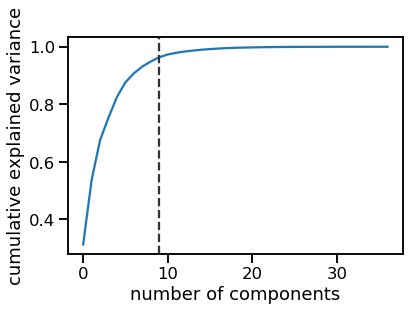

<IPython.core.display.Javascript object>

In [5]:
config_name = "log_temp_pca_onehot"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]
seed = 0

train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates().copy(),
    test_df.drop_duplicates().copy(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

In [6]:
train_filter_df.filter(like="energy_star_rating").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_star_rating  49048 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


<IPython.core.display.Javascript object>

In [7]:
# Set feature columns after data transformations
features_columns = (
    list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
    + pca_cols
    + [f"log10_{col}" for col in log10_transform_cols]
)
if backfill_dict:
    backfill_cols = list(backfill_dict.keys())
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
print(config_name, features_columns, if_one_hot)

log_temp_pca_onehot ['precipitation_inches', 'direction_peak_wind_speed', 'energy_star_rating', 'cooling_degree_days', 'max_wind_speed', 'days_below_30f', 'days_below_10f', 'days_below_20f', 'days_with_fog', 'days_above_80f', 'state_factor', 'direction_max_wind_speed', 'days_below_0f', 'days_above_100f', 'days_above_90f', 'facility_type', 'building_class', 'elevation', 'snowfall_inches', 'heating_degree_days', 'days_above_110f', 'snowdepth_inches', 'year_built', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'log10_floor_area'] True


<IPython.core.display.Javascript object>

base_cat ['august_min_temp', 'may_min_temp', 'precipitation_inches', 'january_max_temp', 'september_avg_temp', 'september_min_temp', 'october_avg_temp', 'november_max_temp', 'february_max_temp', 'july_avg_temp', 'cooling_degree_days', 'days_below_30f', 'december_avg_temp', 'days_below_10f', 'days_above_90f', 'march_min_temp', 'june_min_temp', 'august_max_temp', 'may_max_temp', 'avg_temp', 'december_max_temp', 'snowfall_inches', 'june_max_temp', 'july_min_temp', 'january_min_temp', 'july_max_temp', 'april_avg_temp', 'november_avg_temp', 'april_min_temp', 'year_built', 'march_max_temp', 'direction_peak_wind_speed', 'february_min_temp', 'energy_star_rating', 'march_avg_temp', 'november_min_temp', 'max_wind_speed', 'january_avg_temp', 'days_below_20f', 'days_above_80f', 'days_with_fog', 'state_factor', 'days_below_0f', 'direction_max_wind_speed', 'october_min_temp', 'days_above_100f', 'february_avg_temp', 'facility_type', 'april_max_temp', 'september_max_temp', 'building_class', 'august_av

left_out_year  train_rmse  test_rmse       method
0            1.0   38.083407  58.493645         loyo
1            2.0   38.144868  46.228805         loyo
2            3.0   37.526835  50.650835         loyo
3            4.0   38.765428  42.366159         loyo
4            5.0   40.028246  48.161041         loyo
5            6.0   38.948477  49.547680         loyo
6            0.0   38.580884        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       35.942992
test_rmse        47.424808
dtype: float64
Whole data train RMSE: 36.04547990189584


left_out_year  train_rmse  test_rmse       method
0            1.0   35.523800  57.332701         loyo
1            2.0   35.500389  44.608467         loyo
2            3.0   34.926940  50.408886         loyo
3            4.0   35.889816  40.723973         loyo
4            5.0   37.644089  43.411921         loyo
5            6.0   36.172920  48.062902         loyo
6            0.0   36.045480        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       33.010304
test_rmse        46.133573
dtype: float64
Whole data train RMSE: 32.58593557195493


left_out_year  train_rmse  test_rmse       method
0            1.0   32.502613  56.817422         loyo
1            2.0   32.577896  43.955028         loyo
2            3.0   31.711500  48.757197         loyo
3            4.0   32.976207  40.423782         loyo
4            5.0   34.896113  42.384630         loyo
5            6.0   33.397498  44.463382         loyo
6            0.0   32.585936        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       29.828659
test_rmse        44.753180
dtype: float64
Whole data train RMSE: 29.795052231819124


left_out_year  train_rmse  test_rmse       method
0            1.0   29.542649  56.954903         loyo
1            2.0   29.451867  44.654883         loyo
2            3.0   28.355692  48.615011         loyo
3            4.0   29.758744  39.951659         loyo
4            5.0   31.395673  36.560721         loyo
5            6.0   30.467328  41.781901         loyo
6            0.0   29.795052        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


base_onehot ['august_min_temp', 'may_min_temp', 'precipitation_inches', 'january_max_temp', 'september_avg_temp', 'september_min_temp', 'october_avg_temp', 'november_max_temp', 'february_max_temp', 'july_avg_temp', 'cooling_degree_days', 'days_below_30f', 'december_avg_temp', 'days_below_10f', 'days_above_90f', 'march_min_temp', 'june_min_temp', 'august_max_temp', 'may_max_temp', 'avg_temp', 'december_max_temp', 'snowfall_inches', 'june_max_temp', 'july_min_temp', 'january_min_temp', 'july_max_temp', 'april_avg_temp', 'november_avg_temp', 'april_min_temp', 'year_built', 'march_max_temp', 'direction_peak_wind_speed', 'february_min_temp', 'energy_star_rating', 'march_avg_temp', 'november_min_temp', 'max_wind_speed', 'january_avg_temp', 'days_below_20f', 'days_above_80f', 'days_with_fog', 'state_factor', 'days_below_0f', 'direction_max_wind_speed', 'october_min_temp', 'days_above_100f', 'february_avg_temp', 'facility_type', 'april_max_temp', 'september_max_temp', 'building_class', 'august

left_out_year  train_rmse  test_rmse       method
0            1.0   34.996702  56.884797         loyo
1            2.0   35.038187  45.083070         loyo
2            3.0   34.012346  47.545405         loyo
3            4.0   35.659731  39.747195         loyo
4            5.0   37.031060  41.492694         loyo
5            6.0   36.544549  48.664562         loyo
6            0.0   35.539032        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       32.560255
test_rmse        45.676829
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 32.61343098495192


left_out_year  train_rmse  test_rmse       method
0            1.0   32.056820  55.118739         loyo
1            2.0   31.916051  45.768307         loyo
2            3.0   31.031913  46.805808         loyo
3            4.0   32.569534  39.281643         loyo
4            5.0   34.132191  38.678875         loyo
5            6.0   33.655021  48.407601         loyo
6            0.0   32.613431        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       29.697676
test_rmse        44.075977
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 29.73049460788249


left_out_year  train_rmse  test_rmse       method
0            1.0   29.511443  54.058861         loyo
1            2.0   28.951991  42.602037         loyo
2            3.0   28.186420  46.279741         loyo
3            4.0   29.564504  38.045568         loyo
4            5.0   31.160804  39.418592         loyo
5            6.0   30.810896  44.051062         loyo
6            0.0   29.730495        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       26.749062
test_rmse        43.615155
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 26.862714668517278


left_out_year  train_rmse  test_rmse       method
0            1.0   26.547528  54.009482         loyo
1            2.0   25.948503  43.389039         loyo
2            3.0   25.036165  45.878859         loyo
3            4.0   26.766537  38.222022         loyo
4            5.0   28.232833  35.816114         loyo
5            6.0   27.962808  44.375417         loyo
6            0.0   26.862715        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


log_onehot ['august_min_temp', 'may_min_temp', 'precipitation_inches', 'january_max_temp', 'september_avg_temp', 'september_min_temp', 'october_avg_temp', 'november_max_temp', 'february_max_temp', 'july_avg_temp', 'cooling_degree_days', 'days_below_30f', 'december_avg_temp', 'days_below_10f', 'days_above_90f', 'march_min_temp', 'june_min_temp', 'august_max_temp', 'may_max_temp', 'avg_temp', 'december_max_temp', 'snowfall_inches', 'june_max_temp', 'july_min_temp', 'january_min_temp', 'july_max_temp', 'april_avg_temp', 'november_avg_temp', 'april_min_temp', 'year_built', 'march_max_temp', 'direction_peak_wind_speed', 'february_min_temp', 'energy_star_rating', 'march_avg_temp', 'november_min_temp', 'max_wind_speed', 'january_avg_temp', 'days_below_20f', 'days_above_80f', 'days_with_fog', 'state_factor', 'days_below_0f', 'direction_max_wind_speed', 'october_min_temp', 'days_above_100f', 'february_avg_temp', 'facility_type', 'april_max_temp', 'september_max_temp', 'building_class', 'august_

left_out_year  train_rmse  test_rmse       method
0            1.0   35.040223  56.901482         loyo
1            2.0   34.928139  45.234739         loyo
2            3.0   34.185448  47.572322         loyo
3            4.0   35.609639  39.737427         loyo
4            5.0   37.033377  43.822836         loyo
5            6.0   36.445672  50.505268         loyo
6            0.0   35.520642        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       32.582842
test_rmse        46.088864
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 32.66167321836658


left_out_year  train_rmse  test_rmse       method
0            1.0   32.252612  55.856971         loyo
1            2.0   31.954627  47.108272         loyo
2            3.0   30.961320  46.628354         loyo
3            4.0   32.539618  38.806592         loyo
4            5.0   34.145738  39.989156         loyo
5            6.0   33.643140  48.143837         loyo
6            0.0   32.661673        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       29.695505
test_rmse        44.130665
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 29.835196851515253


left_out_year  train_rmse  test_rmse       method
0            1.0   29.479674  55.032398         loyo
1            2.0   29.129466  43.315949         loyo
2            3.0   27.954151  46.590558         loyo
3            4.0   29.639588  38.271641         loyo
4            5.0   31.228802  36.284073         loyo
5            6.0   30.741346  45.289370         loyo
6            0.0   29.835197        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       26.732202
test_rmse        43.718525
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 26.811110156088517


left_out_year  train_rmse  test_rmse       method
0            1.0   26.591425  53.752386         loyo
1            2.0   25.986335  42.530426         loyo
2            3.0   25.003740  46.242945         loyo
3            4.0   26.608423  38.115668         loyo
4            5.0   28.174520  35.244765         loyo
5            6.0   28.028766  46.424959         loyo
6            0.0   26.811110        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Fitting PCA with 9 components
log_temp_pca_onehot ['precipitation_inches', 'direction_peak_wind_speed', 'energy_star_rating', 'cooling_degree_days', 'max_wind_speed', 'days_below_30f', 'days_below_10f', 'days_below_20f', 'days_with_fog', 'days_above_80f', 'state_factor', 'direction_max_wind_speed', 'days_below_0f', 'days_above_100f', 'days_above_90f', 'facility_type', 'building_class', 'elevation', 'snowfall_inches', 'heating_degree_days', 'days_above_110f', 'snowdepth_inches', 'year_built', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'log10_floor_area'] True
Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'build

left_out_year  train_rmse  test_rmse       method
0            1.0   35.104018  56.990744         loyo
1            2.0   35.023915  44.016143         loyo
2            3.0   34.230723  48.269613         loyo
3            4.0   35.705709  45.519112         loyo
4            5.0   37.001191  36.827742         loyo
5            6.0   36.574692  46.554005         loyo
6            0.0   35.628035        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       32.630857
test_rmse        45.150137
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 32.738832390192485


left_out_year  train_rmse  test_rmse       method
0            1.0   32.316961  55.409398         loyo
1            2.0   31.933443  43.203854         loyo
2            3.0   31.116206  46.931184         loyo
3            4.0   32.643432  43.175575         loyo
4            5.0   34.210653  35.792453         loyo
5            6.0   33.564449  46.388360         loyo
6            0.0   32.738832        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       29.726934
test_rmse        44.904264
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 29.909631544934122


left_out_year  train_rmse  test_rmse       method
0            1.0   29.628040  55.116676         loyo
1            2.0   28.864123  43.016879         loyo
2            3.0   28.116306  46.515420         loyo
3            4.0   29.649452  39.181802         loyo
4            5.0   31.271434  39.644610         loyo
5            6.0   30.832247  45.950200         loyo
6            0.0   29.909632        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       26.794804
test_rmse        43.746093
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 27.056377417332772


left_out_year  train_rmse  test_rmse       method
0            1.0   26.726226  54.513941         loyo
1            2.0   26.080089  42.983357         loyo
2            3.0   25.167683  45.913403         loyo
3            4.0   26.646053  40.035474         loyo
4            5.0   28.199758  35.132350         loyo
5            6.0   27.949015  43.898035         loyo
6            0.0   27.056377        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Fitting PCA with 9 components
log_temp_pca_onehot_impute ['precipitation_inches', 'log10_floor_area', 'temp_pca6', 'cooling_degree_days', 'days_below_30f', 'temp_pca9', 'days_below_10f', 'temp_pca1', 'days_above_90f', 'snowfall_inches', 'year_built', 'direction_peak_wind_speed', 'max_wind_speed', 'days_below_20f', 'days_above_80f', 'days_with_fog', 'state_factor', 'days_below_0f', 'direction_max_wind_speed', 'temp_pca7', 'days_above_100f', 'temp_pca5', 'temp_pca4', 'facility_type', 'temp_pca2', 'building_class', 'elevation', 'temp_pca8', 'heating_degree_days', 'days_above_110f', 'snowdepth_inches', 'temp_pca3', 'backfilled_energy_star_rating'] True
Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'sta

left_out_year  train_rmse  test_rmse       method
0            1.0   35.309008  57.319091         loyo
1            2.0   35.292810  44.130438         loyo
2            3.0   34.344565  50.083571         loyo
3            4.0   36.053874  44.139379         loyo
4            5.0   37.243113  37.513438         loyo
5            6.0   36.691518  51.340407         loyo
6            0.0   35.901838        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       32.820552
test_rmse        47.090982
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 32.949251851226116


left_out_year  train_rmse  test_rmse       method
0            1.0   32.458043  56.547918         loyo
1            2.0   32.164773  43.104673         loyo
2            3.0   31.283299  48.191101         loyo
3            4.0   32.879010  43.859239         loyo
4            5.0   34.280044  39.108389         loyo
5            6.0   33.858141  51.734570         loyo
6            0.0   32.949252        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       29.947105
test_rmse        45.430847
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 30.03941999670992


left_out_year  train_rmse  test_rmse       method
0            1.0   29.655210  55.494856         loyo
1            2.0   29.239530  42.797584         loyo
2            3.0   28.218862  47.186981         loyo
3            4.0   30.018353  41.584767         loyo
4            5.0   31.492514  36.764953         loyo
5            6.0   31.058165  48.755944         loyo
6            0.0   30.039420        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

Running catboost
Modeling 1...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 2...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 3...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 4...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 5...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Modeling 6...
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Average RMSE:
left_out_year     3.500000
train_rmse       27.042683
test_rmse        43.839393
dtype: float64
Columns to be dummied: ['facility_type', 'state_factor', 'building_class']
Whole data train RMSE: 27.245053840155087


left_out_year  train_rmse  test_rmse       method
0            1.0   26.879007  55.590068         loyo
1            2.0   26.284468  42.762746         loyo
2            3.0   25.265661  46.829203         loyo
3            4.0   27.144702  39.055842         loyo
4            5.0   28.613866  35.344229         loyo
5            6.0   28.068395  43.454272         loyo
6            0.0   27.245054        NaN  whole train

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 26))
/Users/diana/Documents/projects/widsdatathon2022/utils/visualize.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

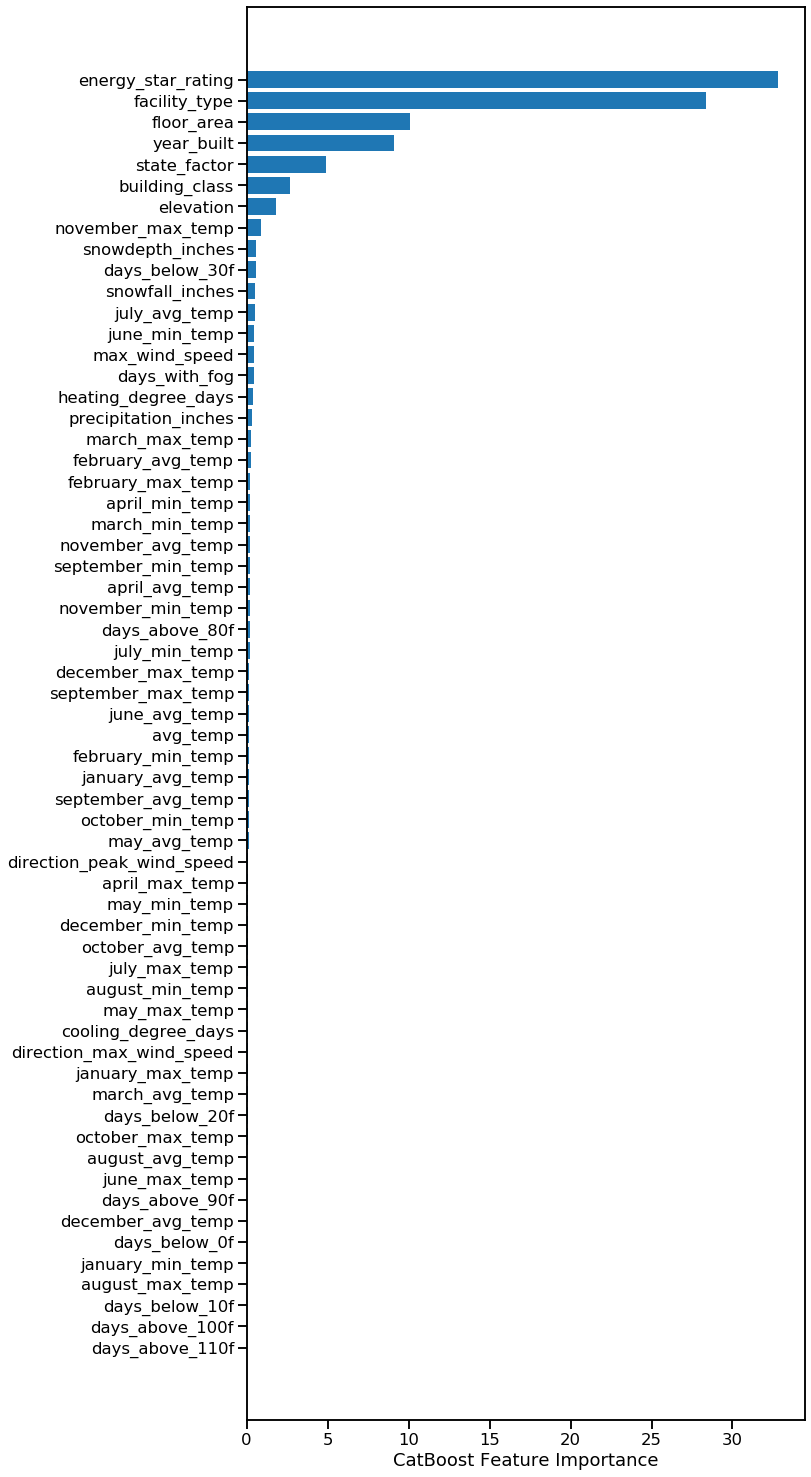

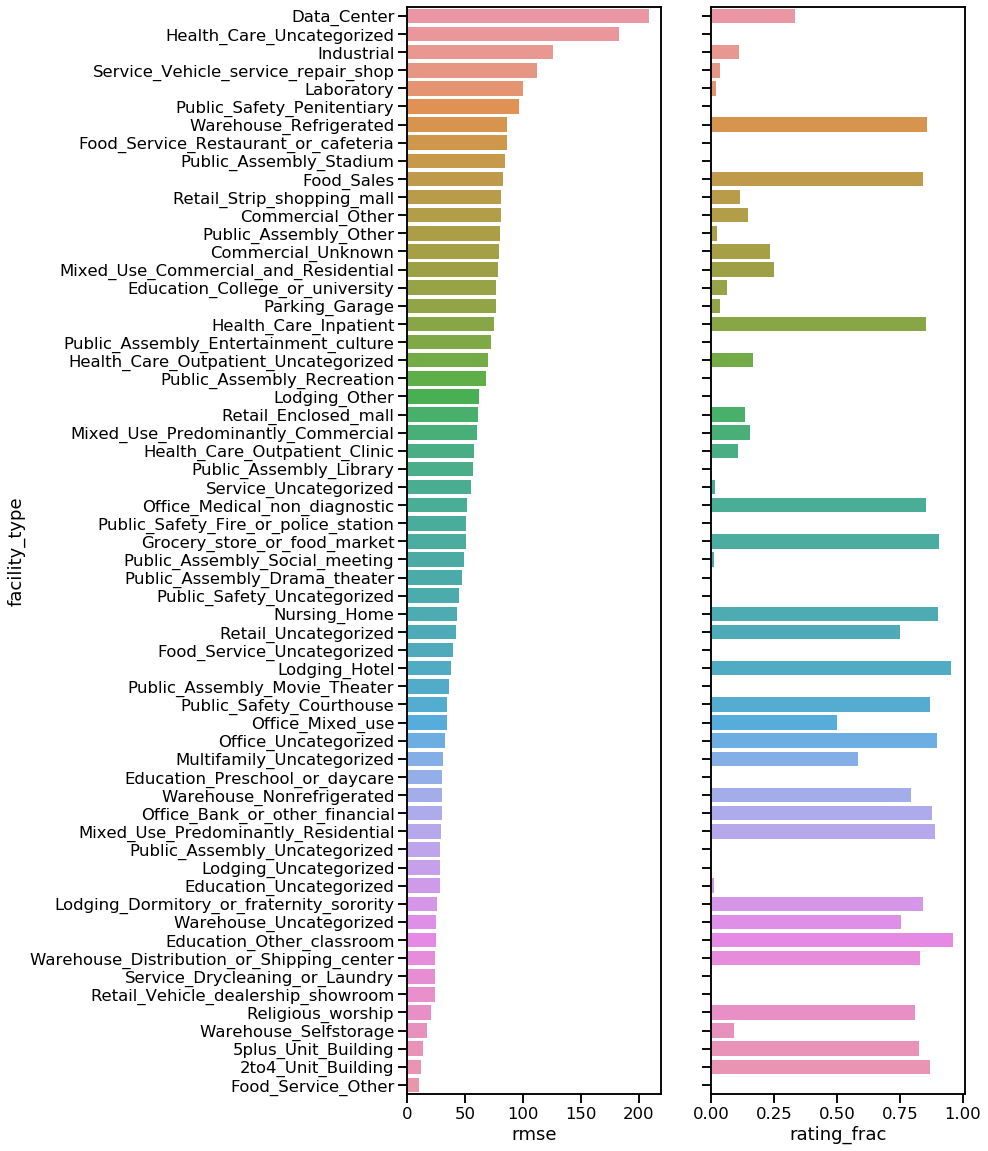

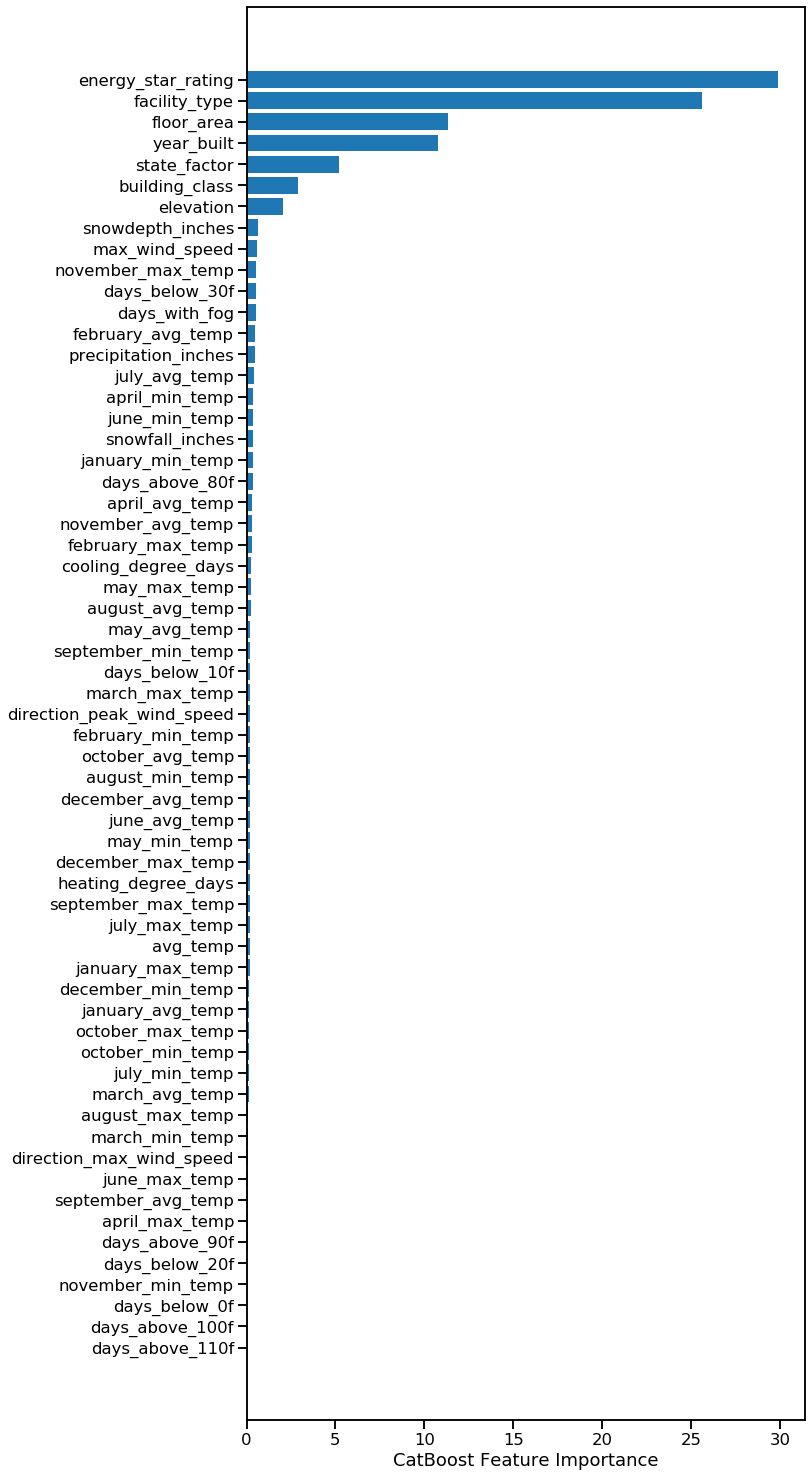

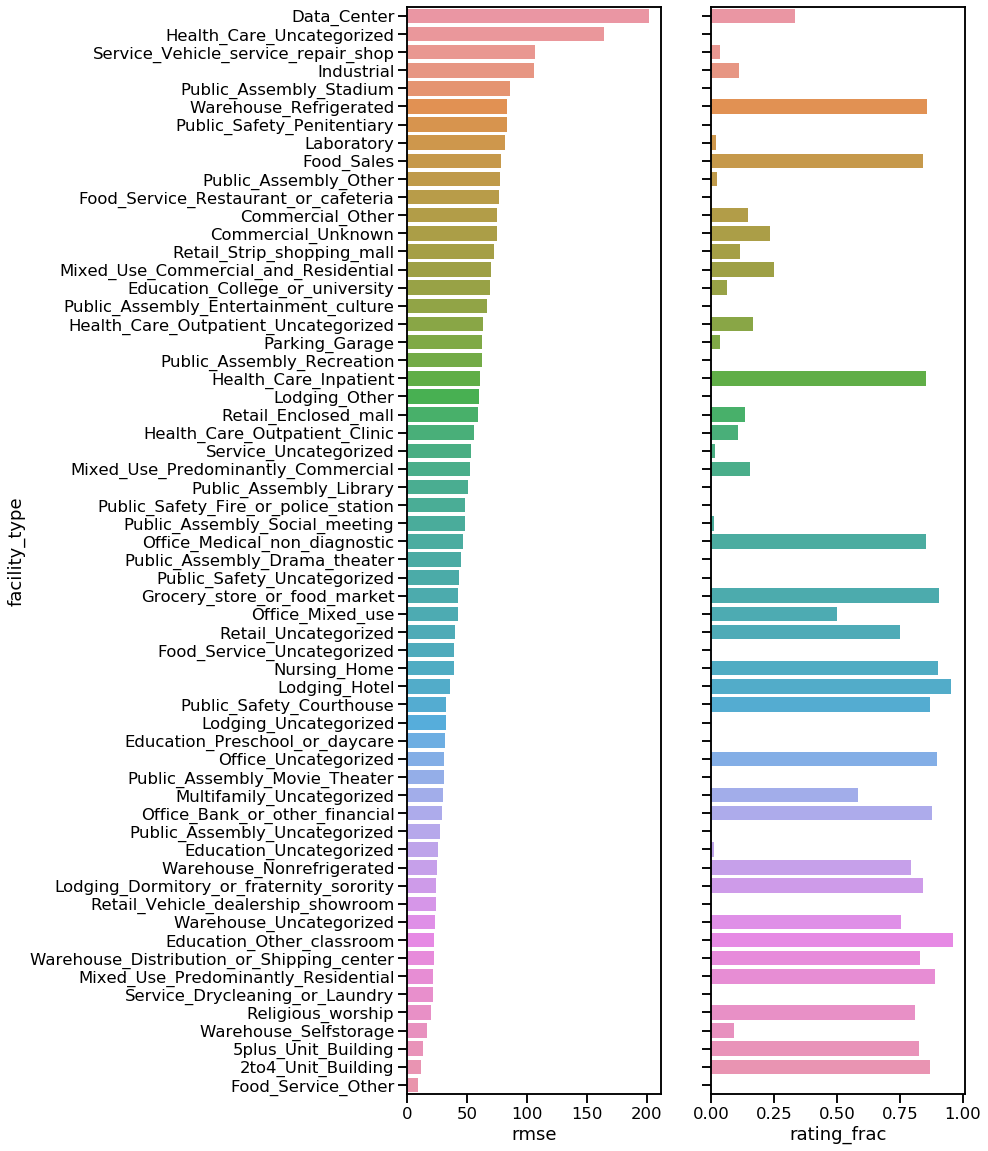

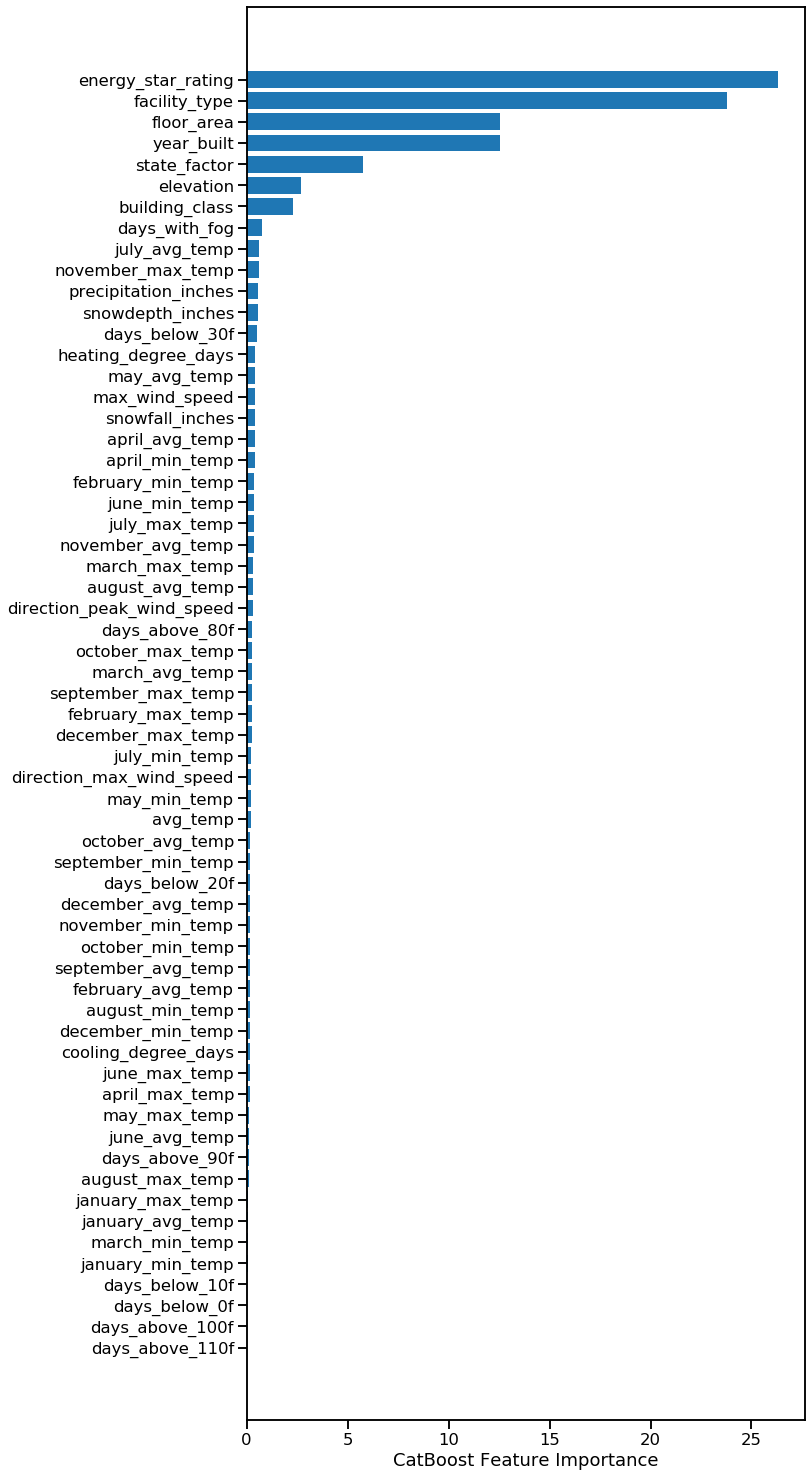

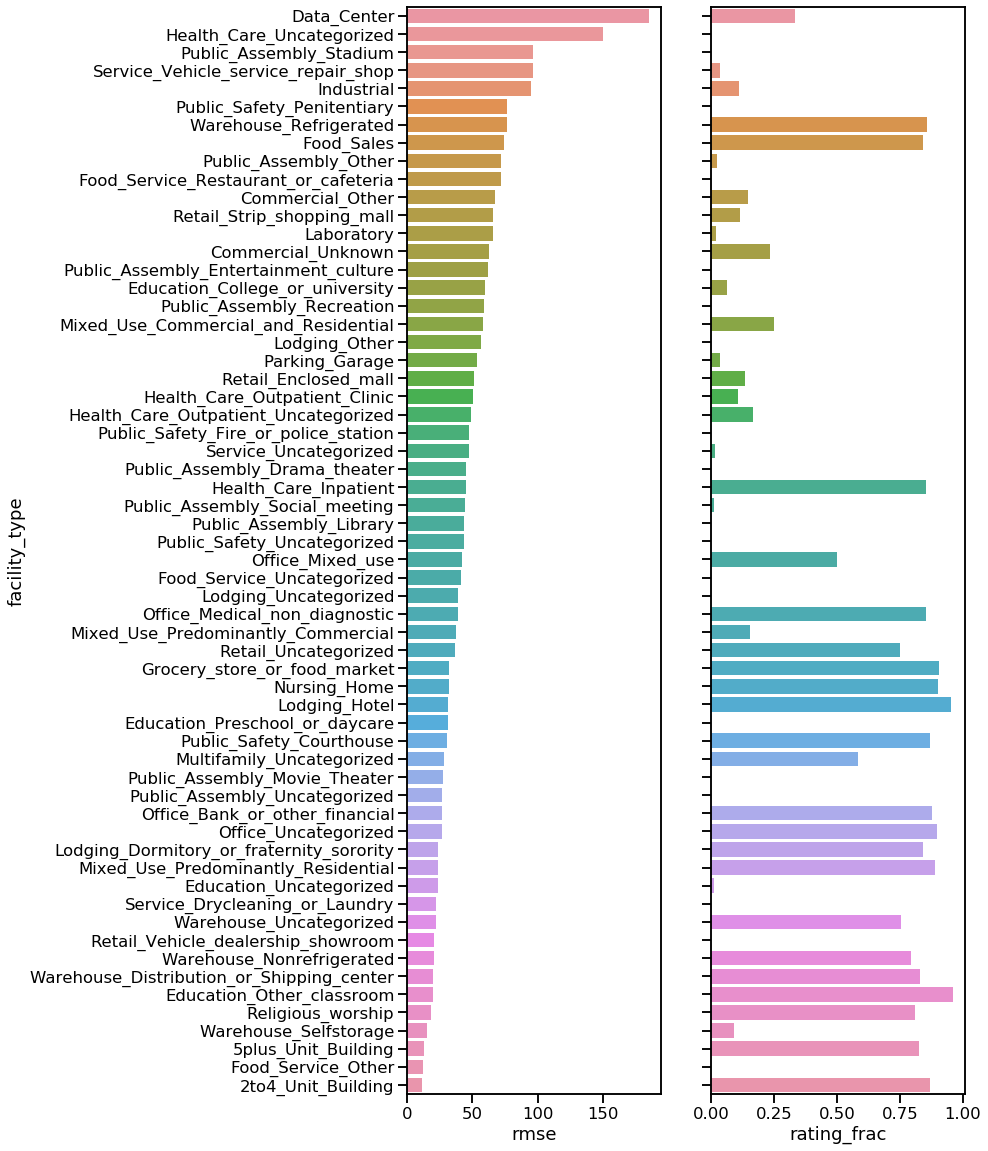

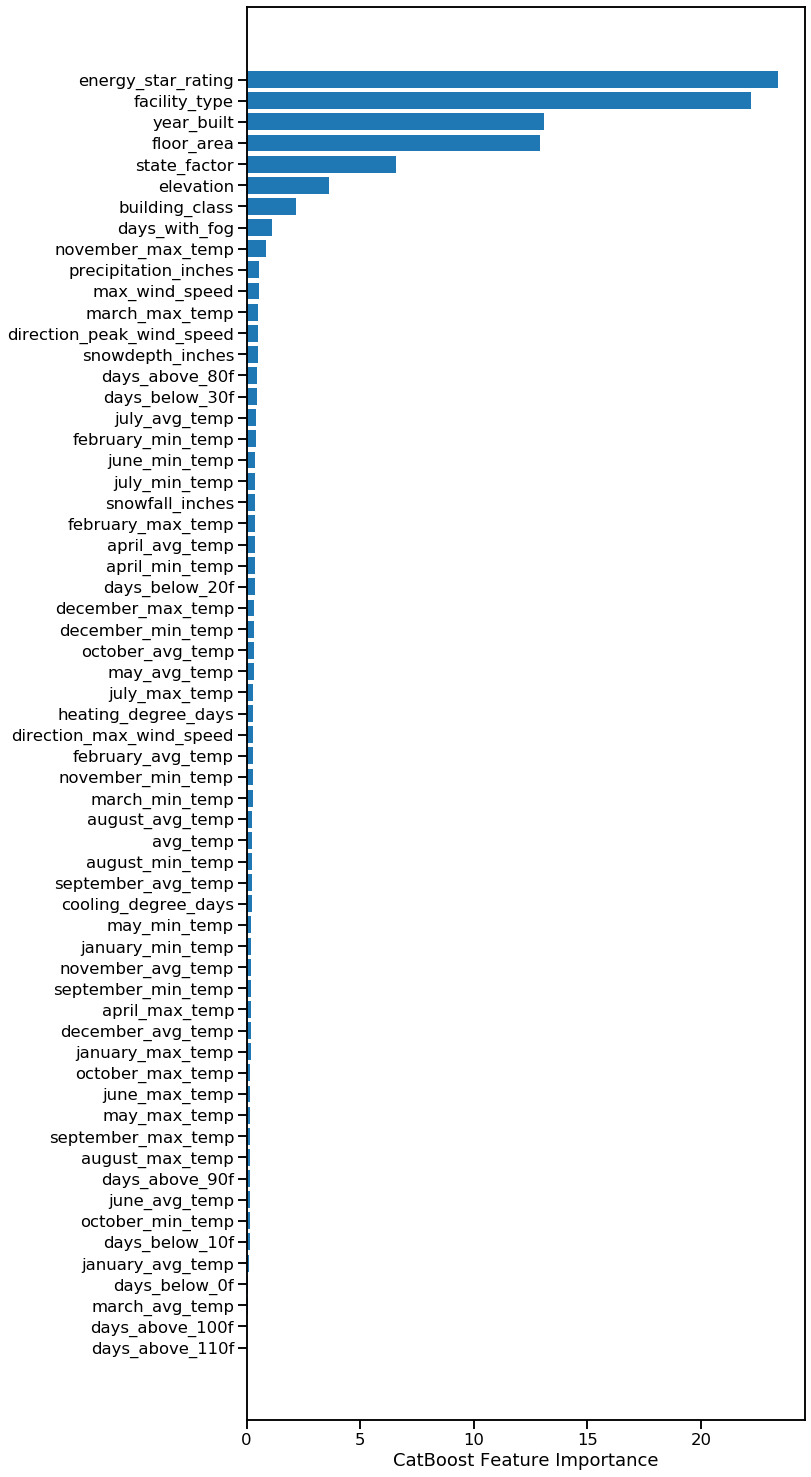

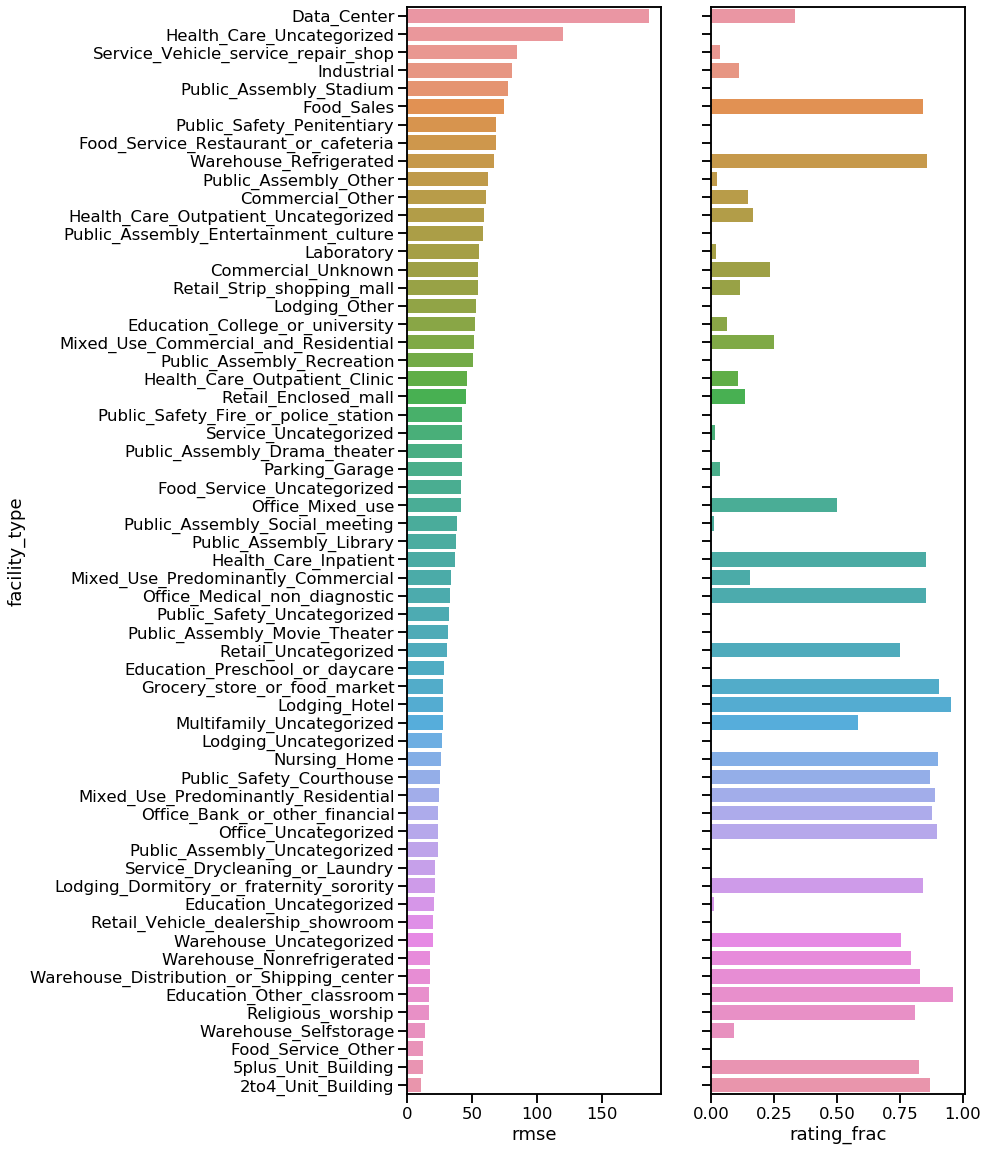

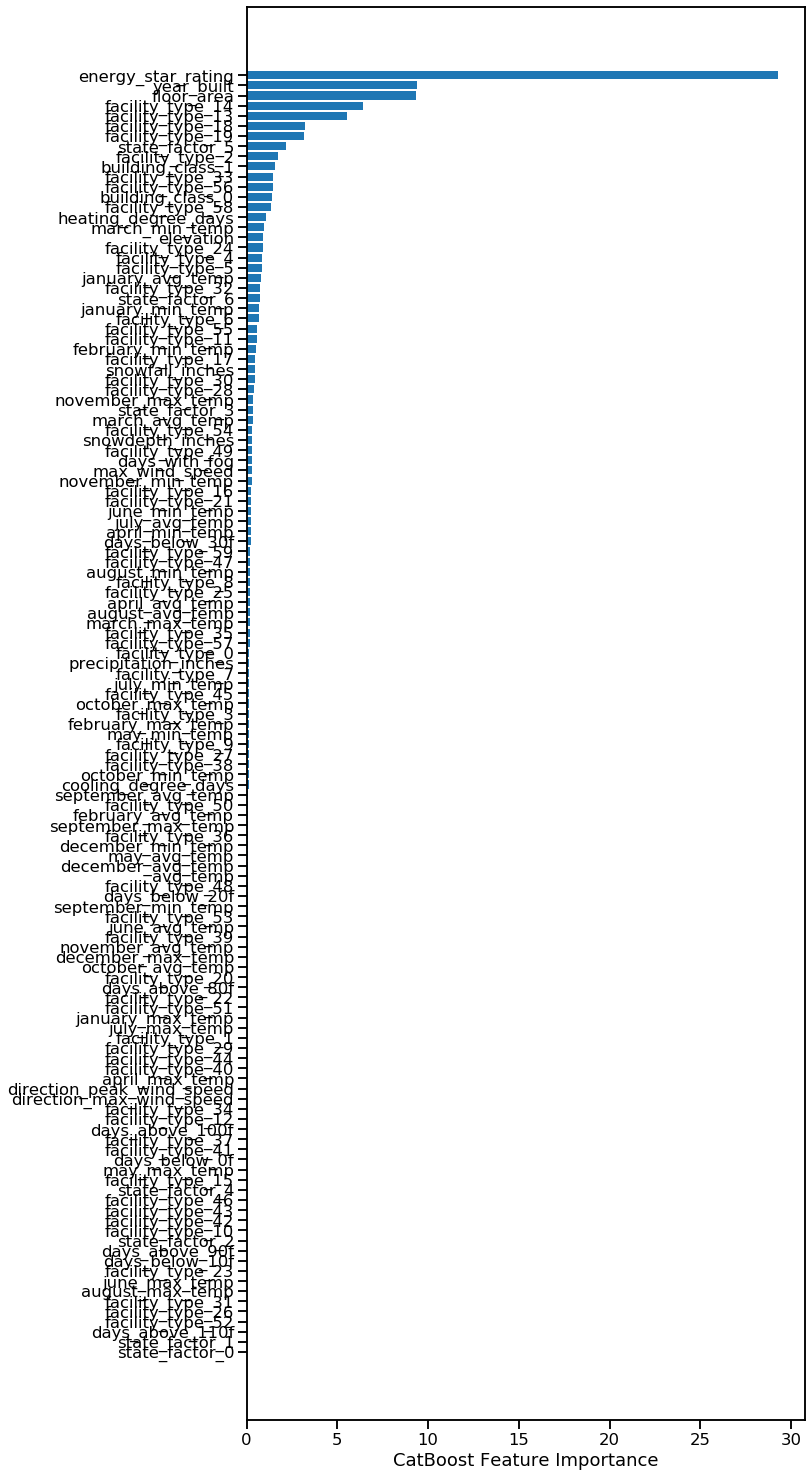

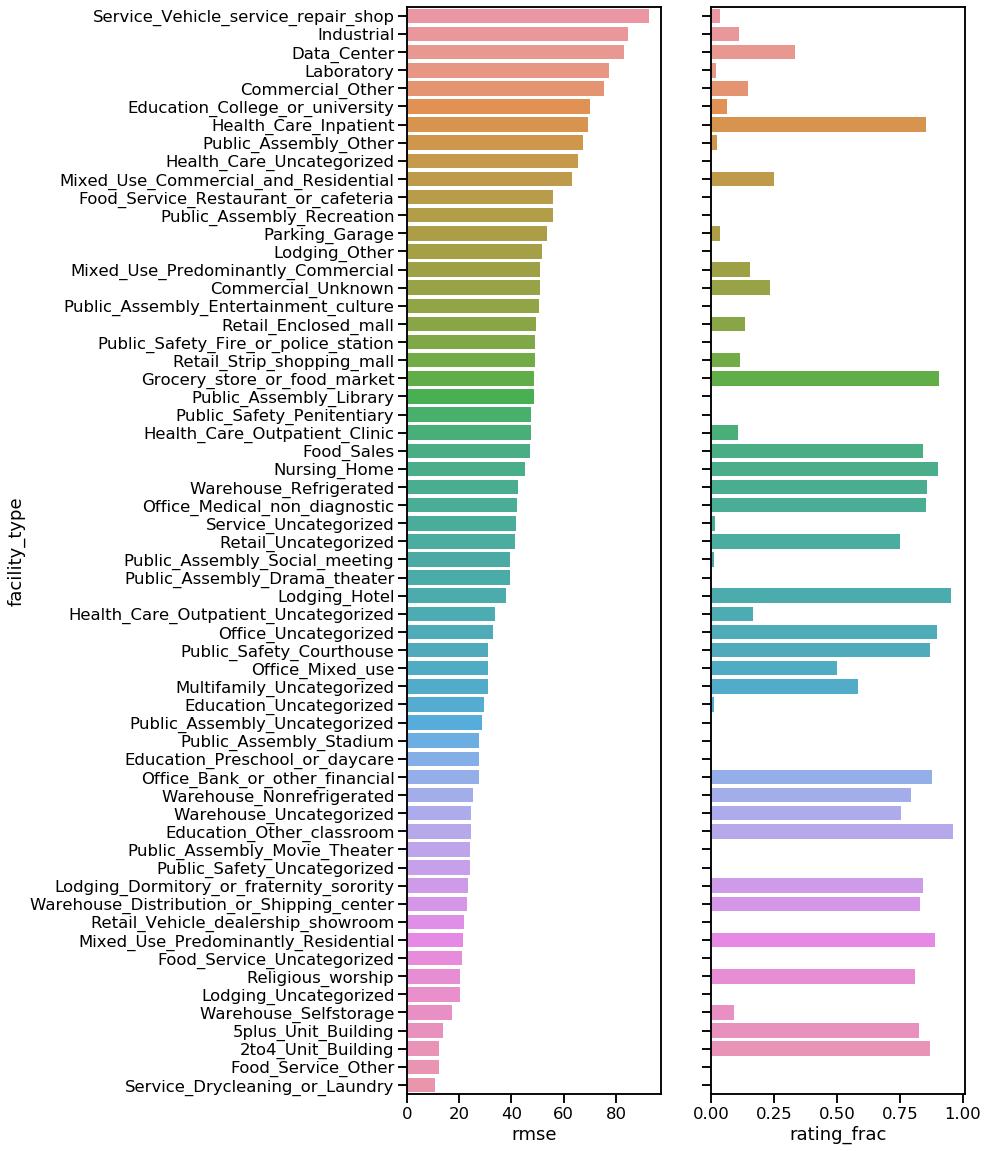

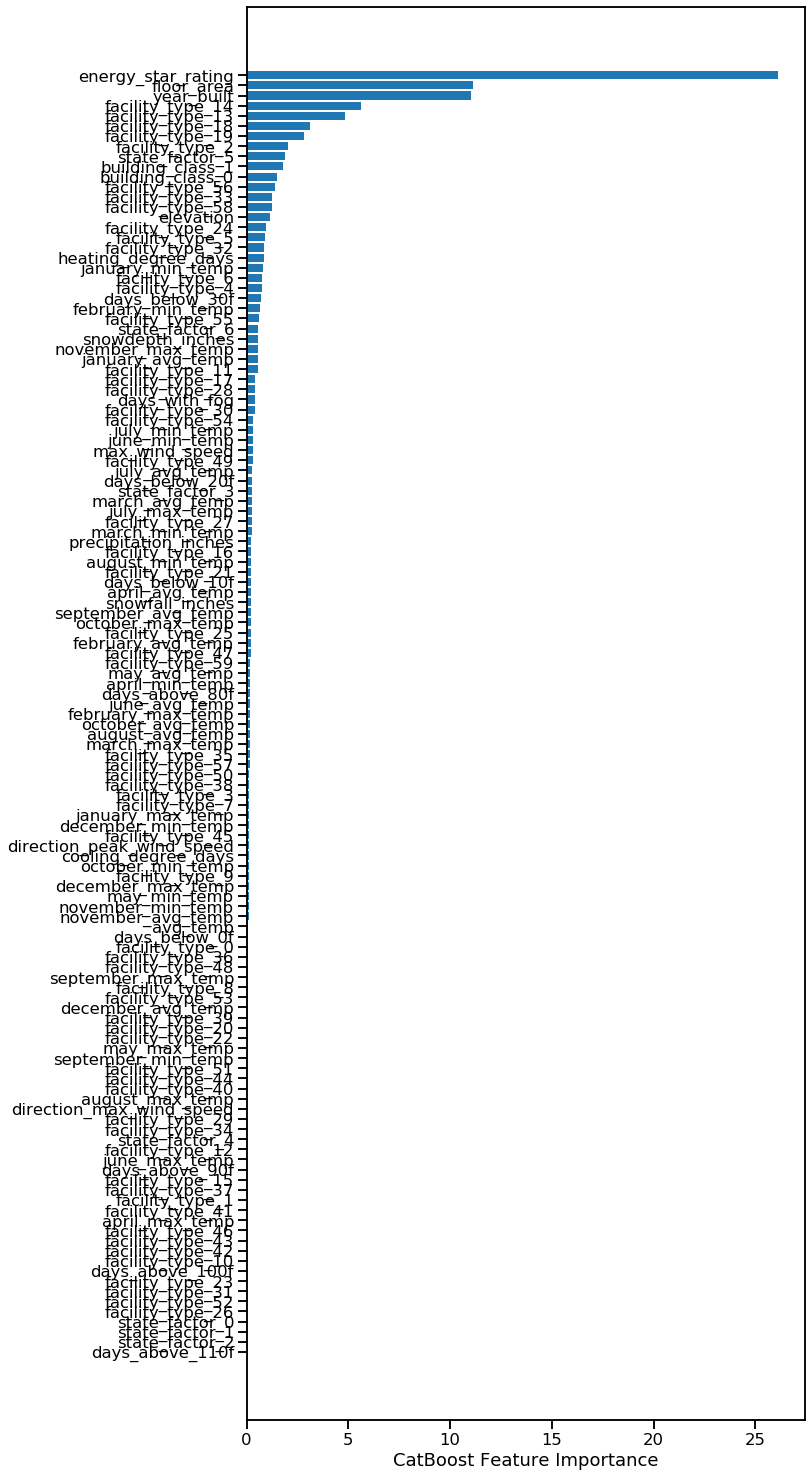

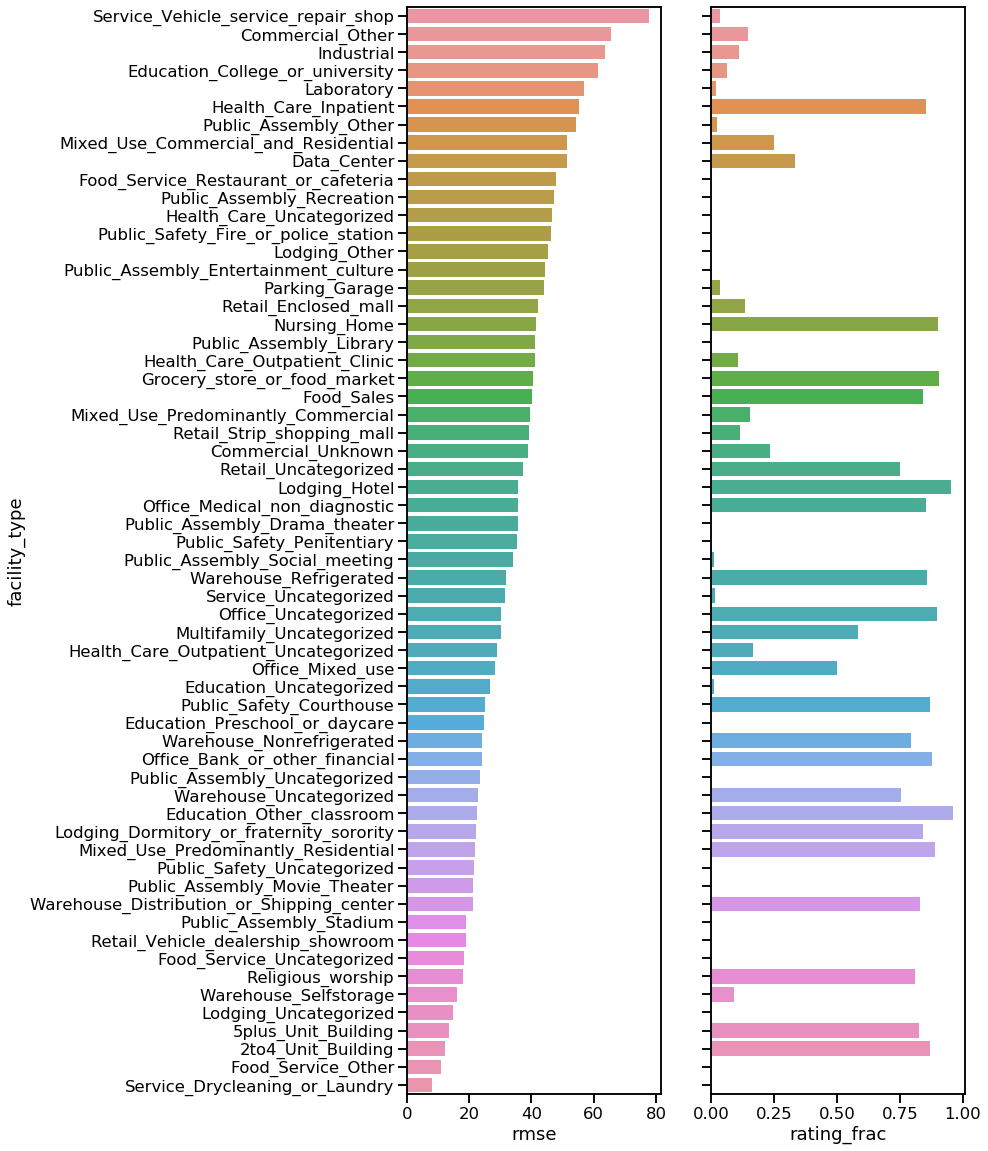

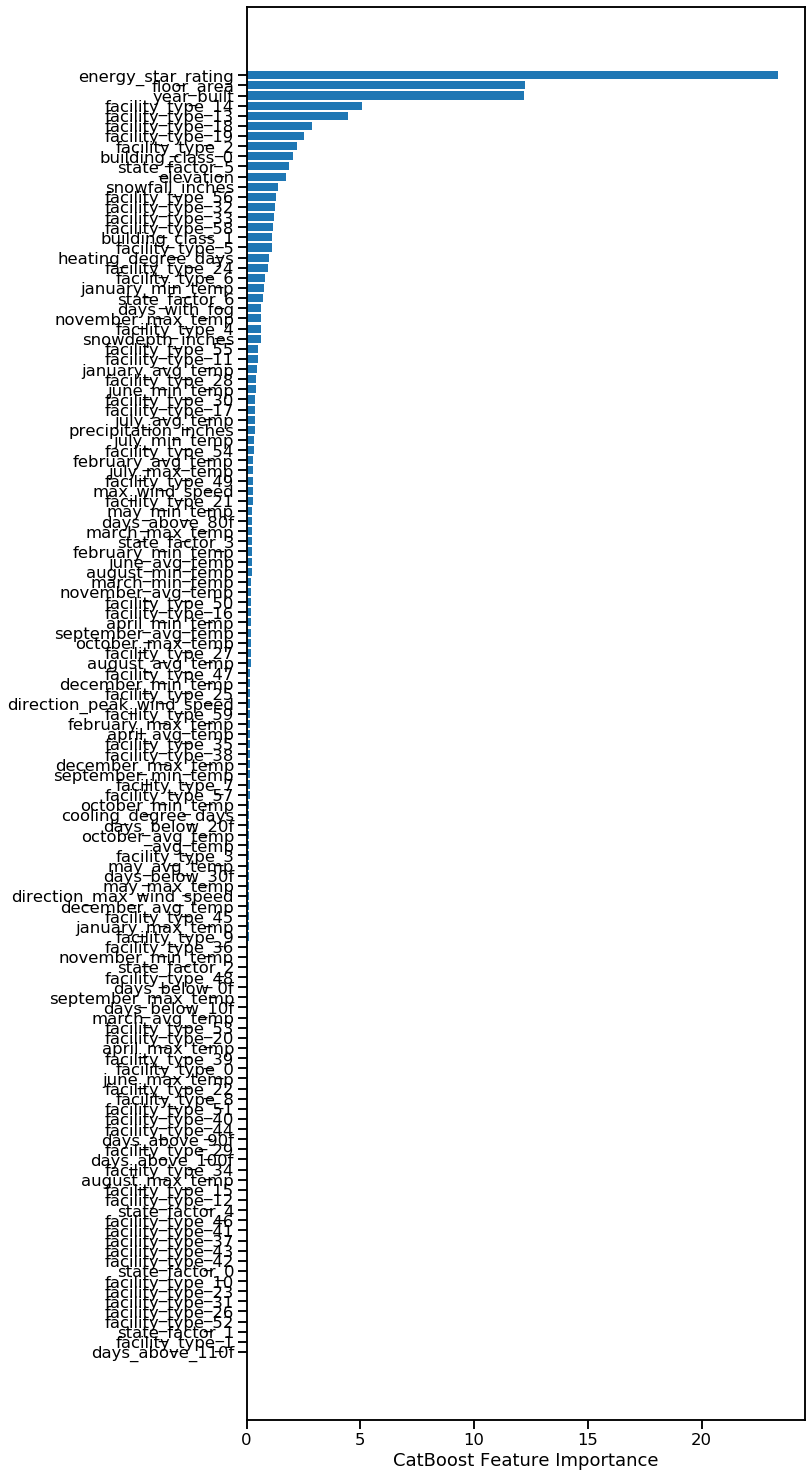

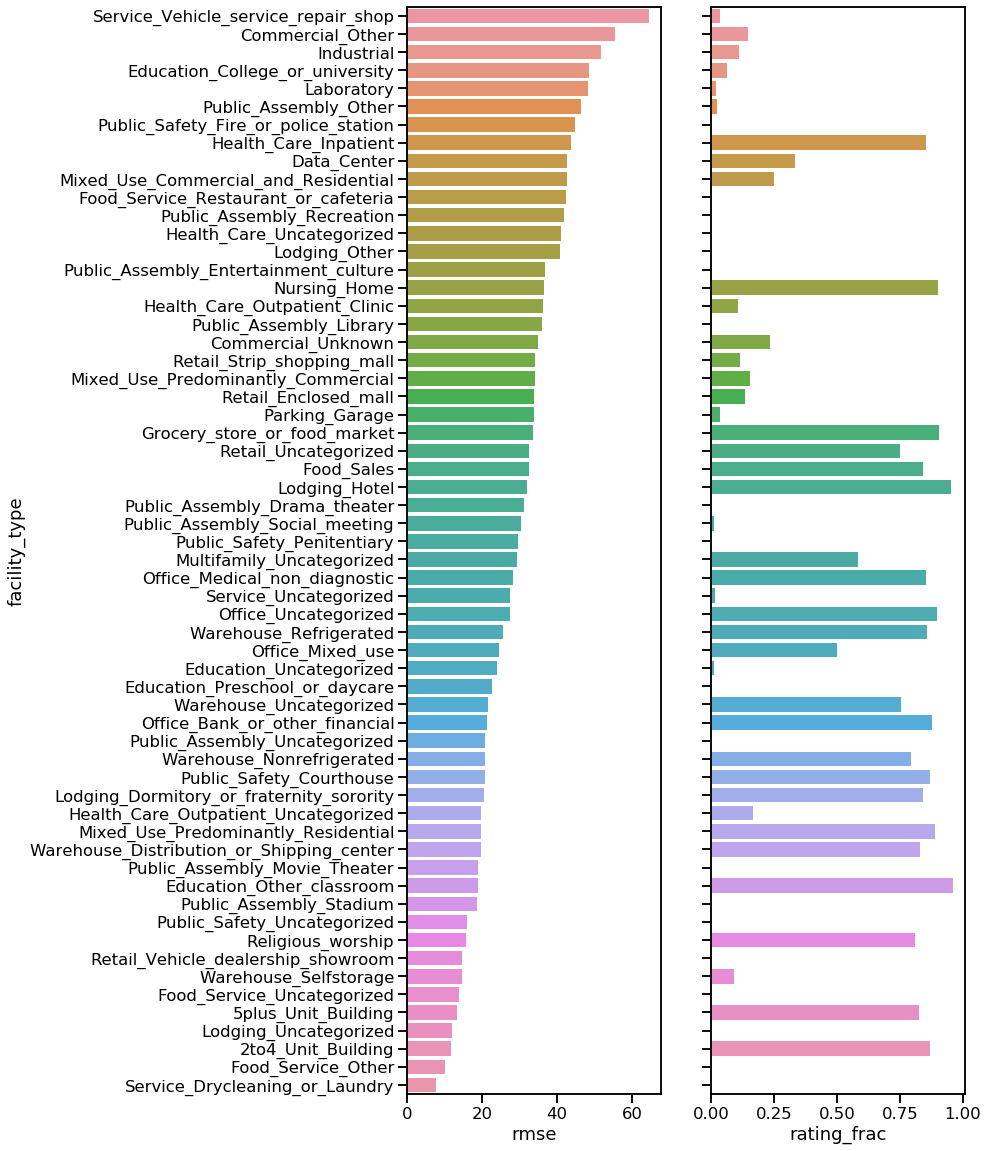

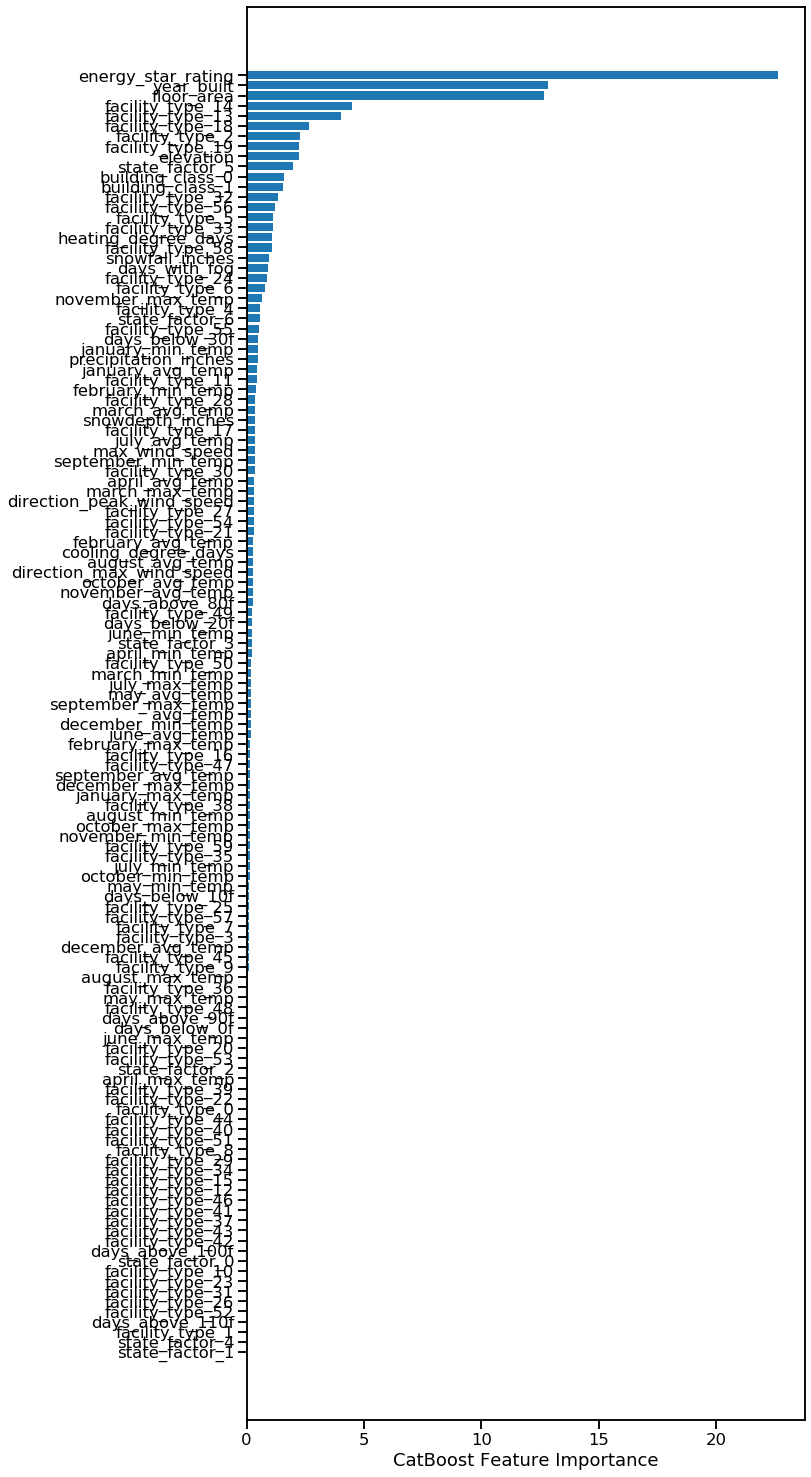

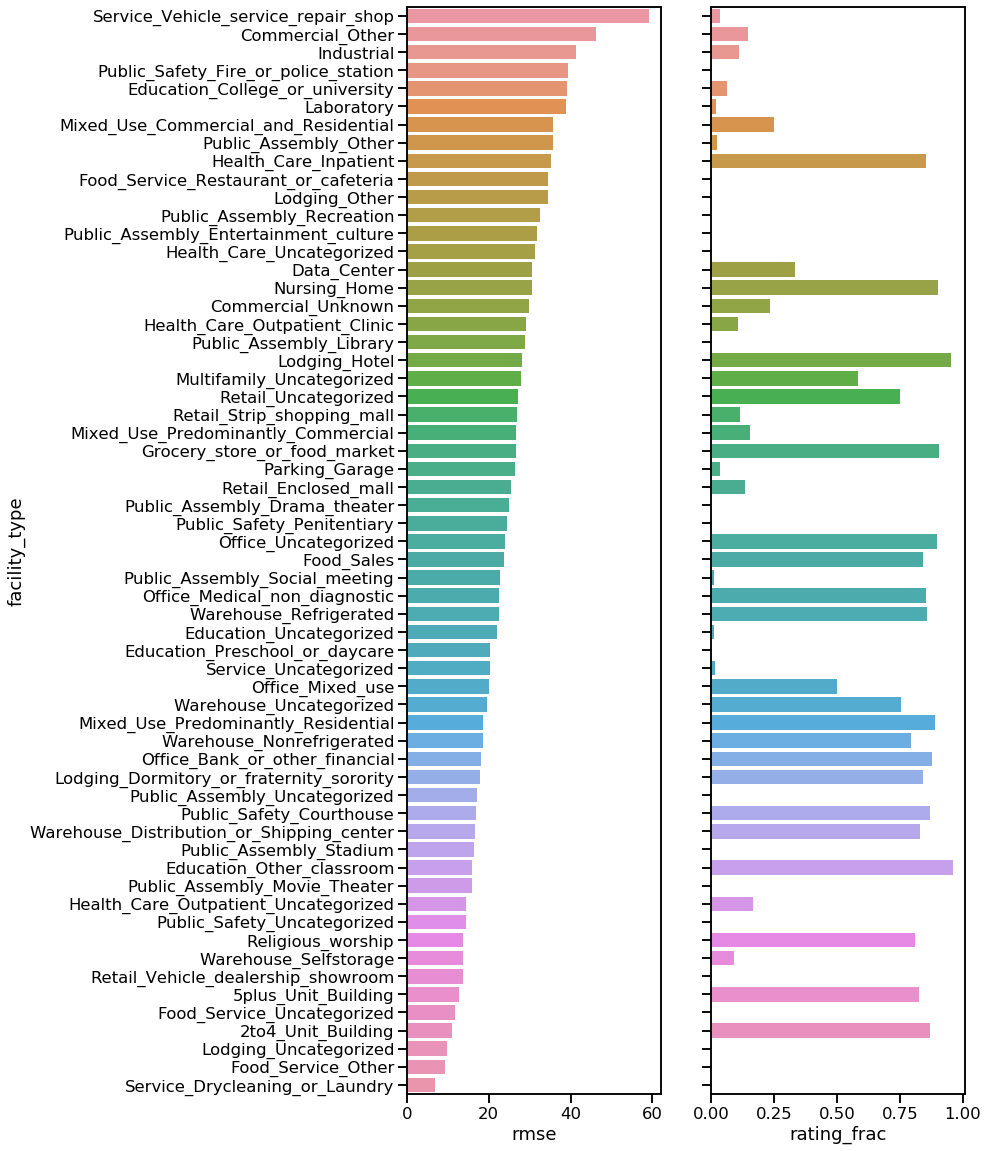

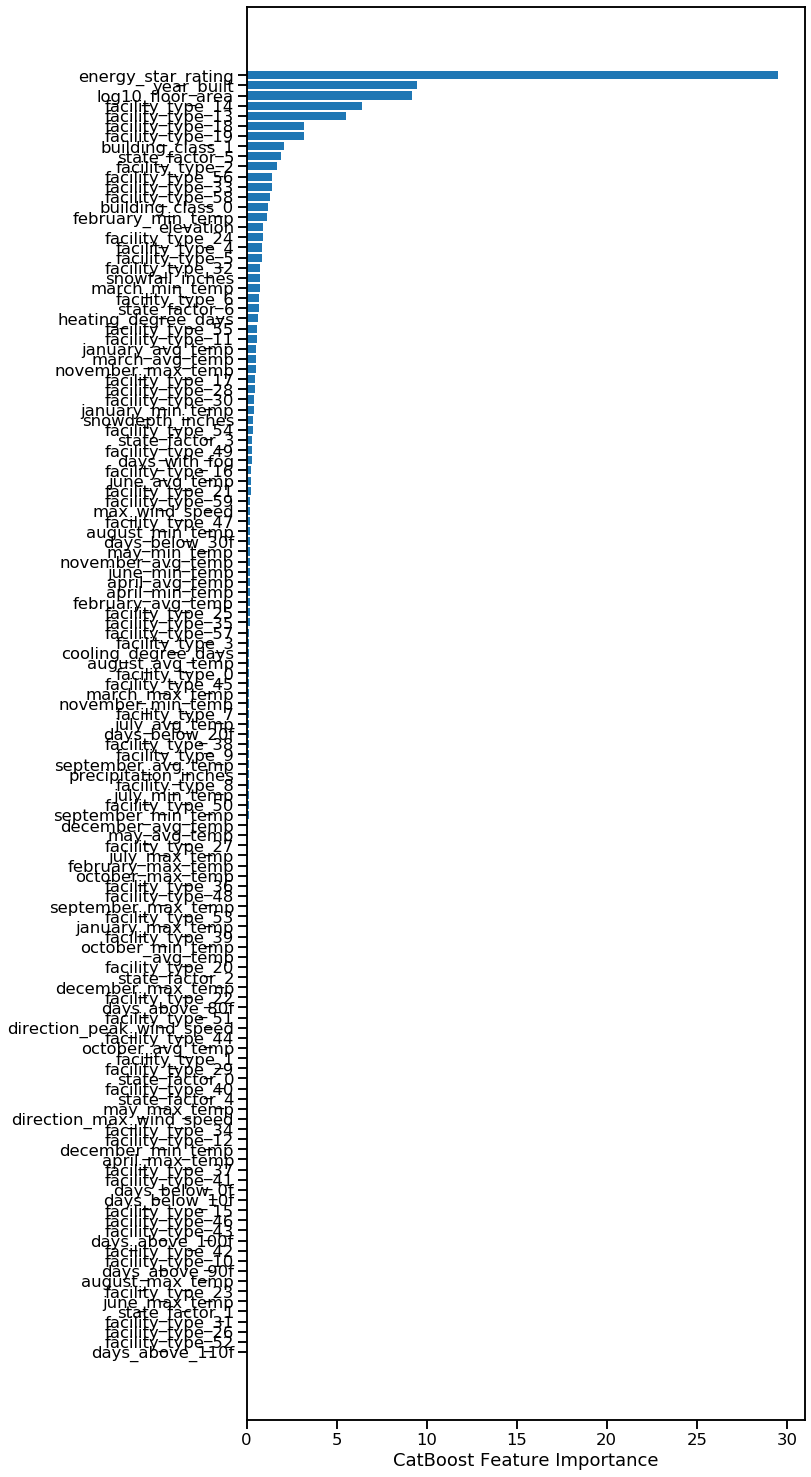

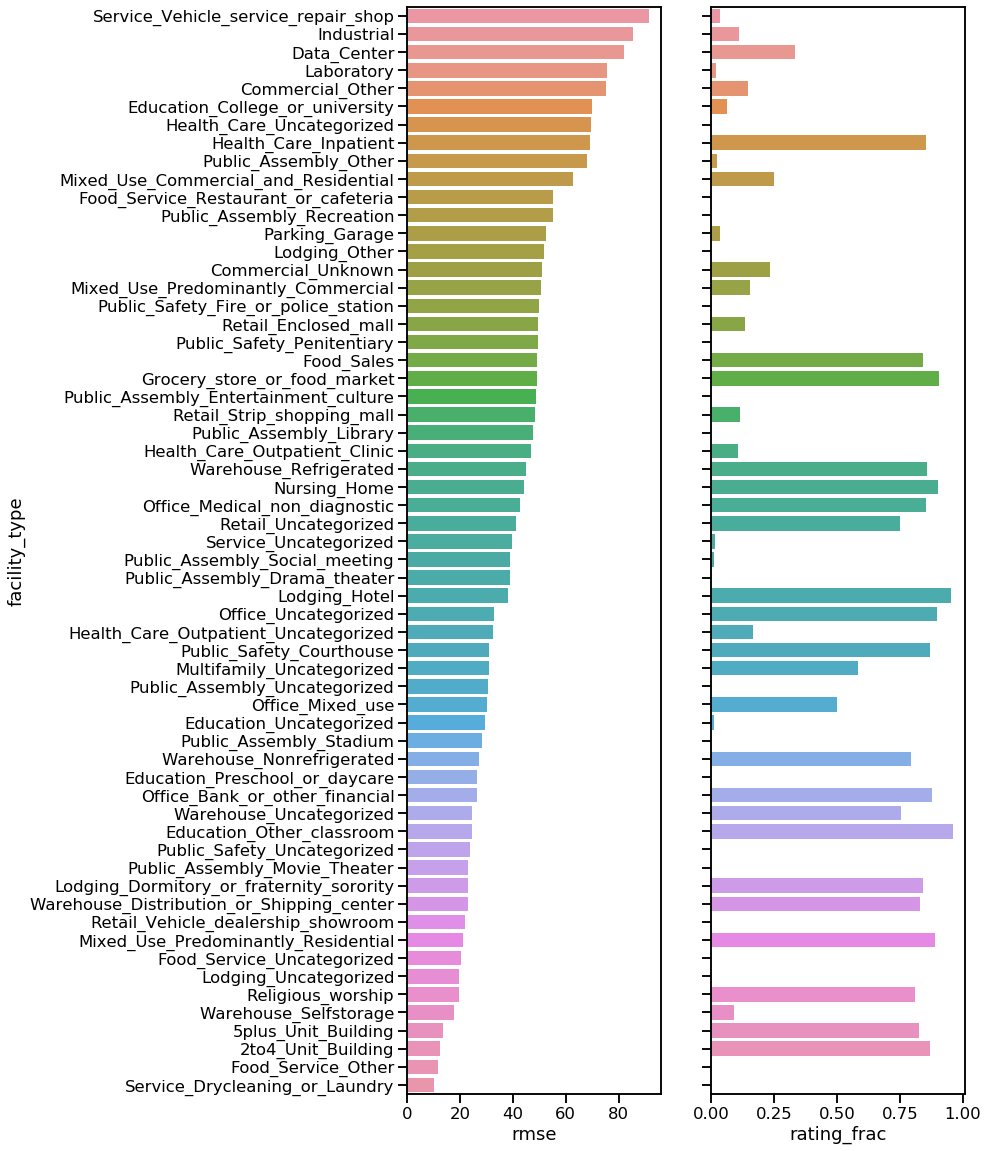

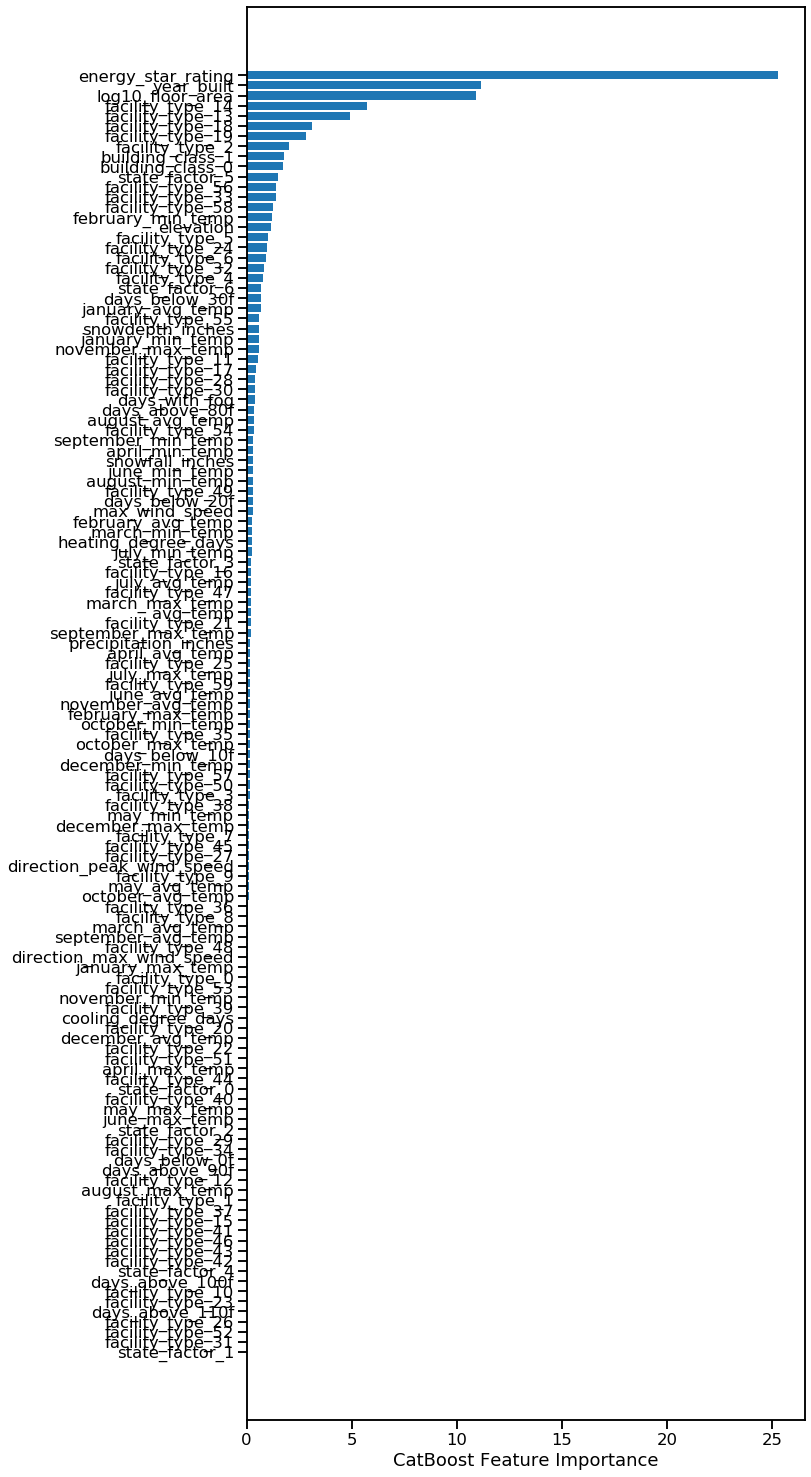

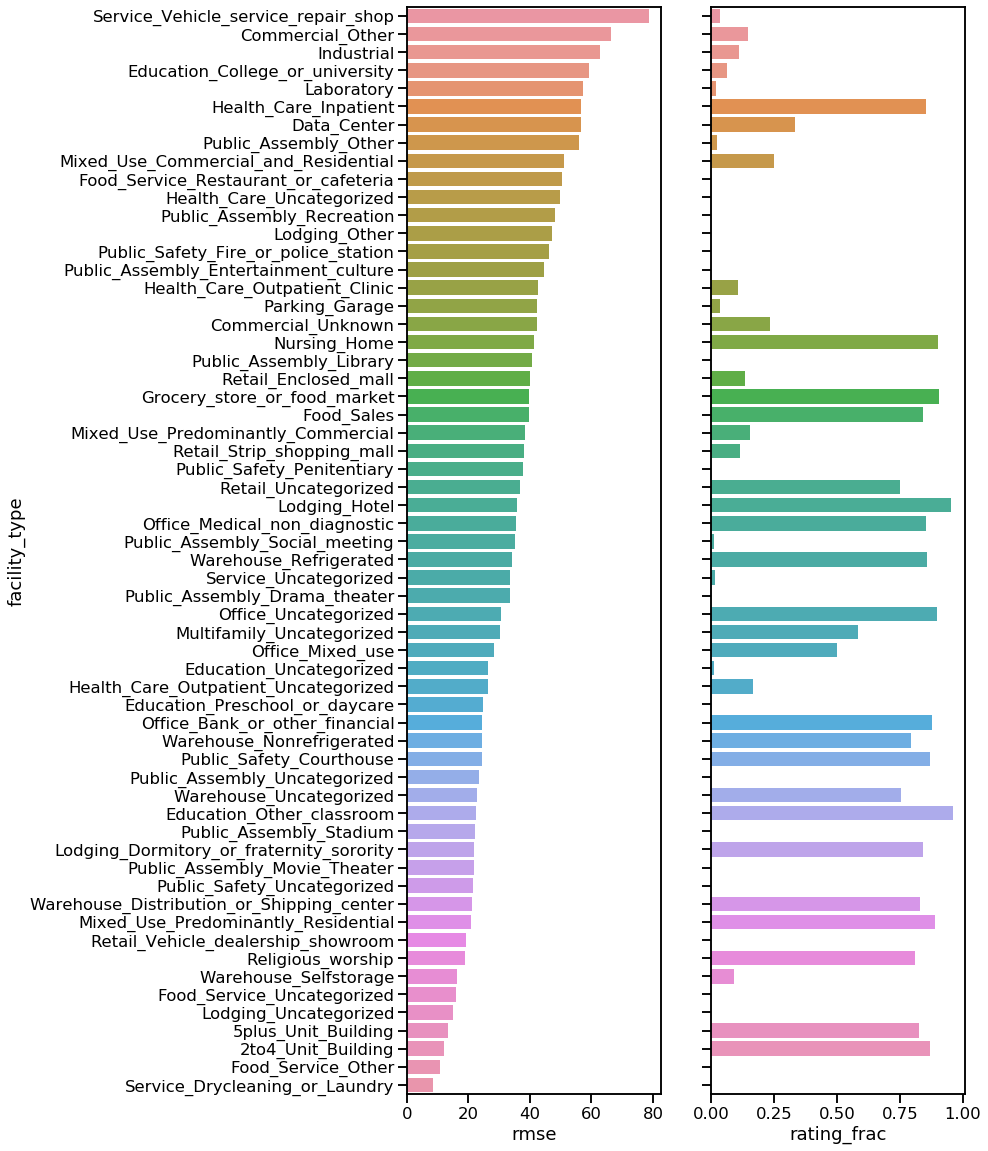

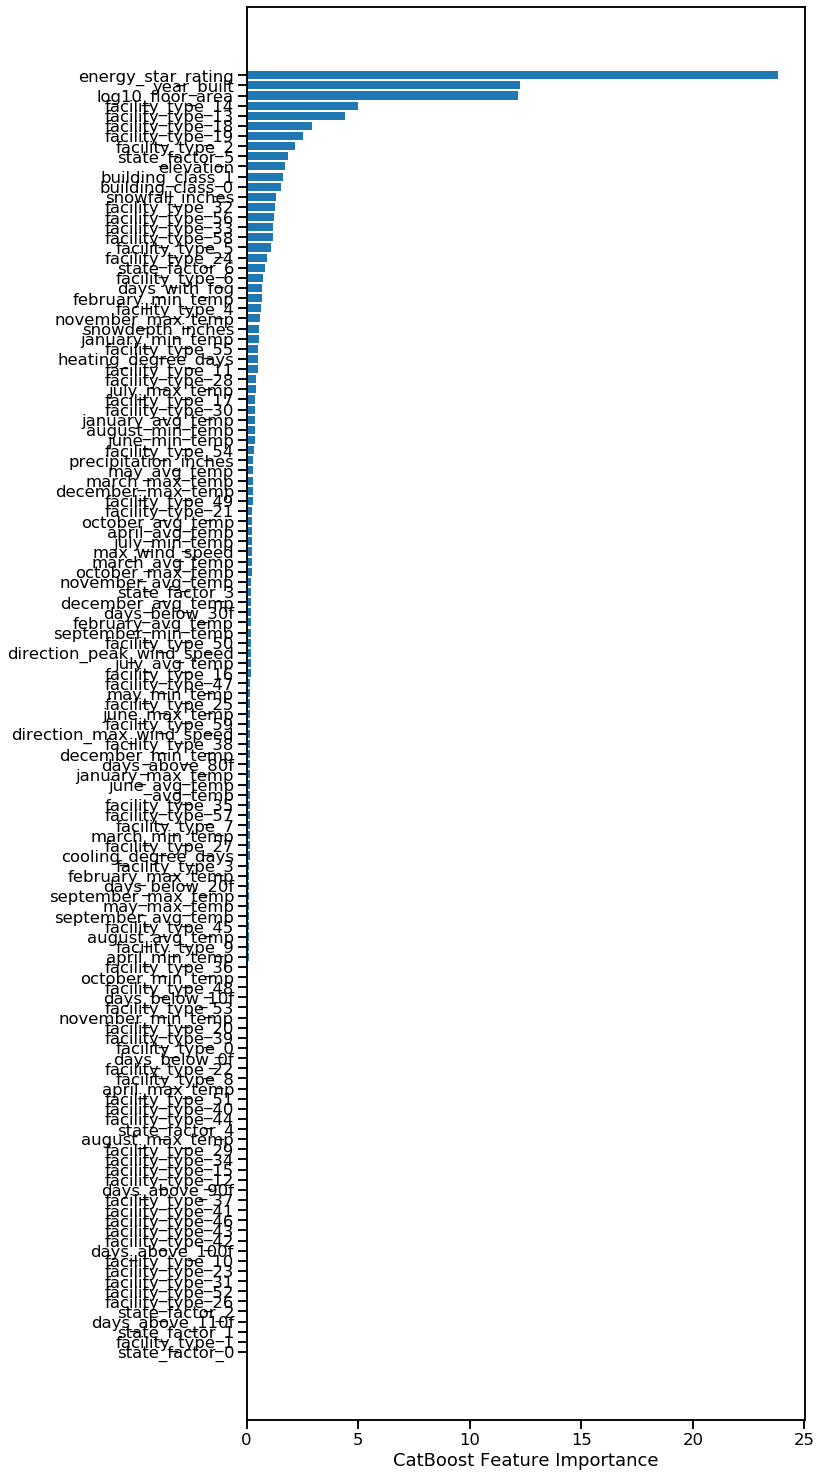

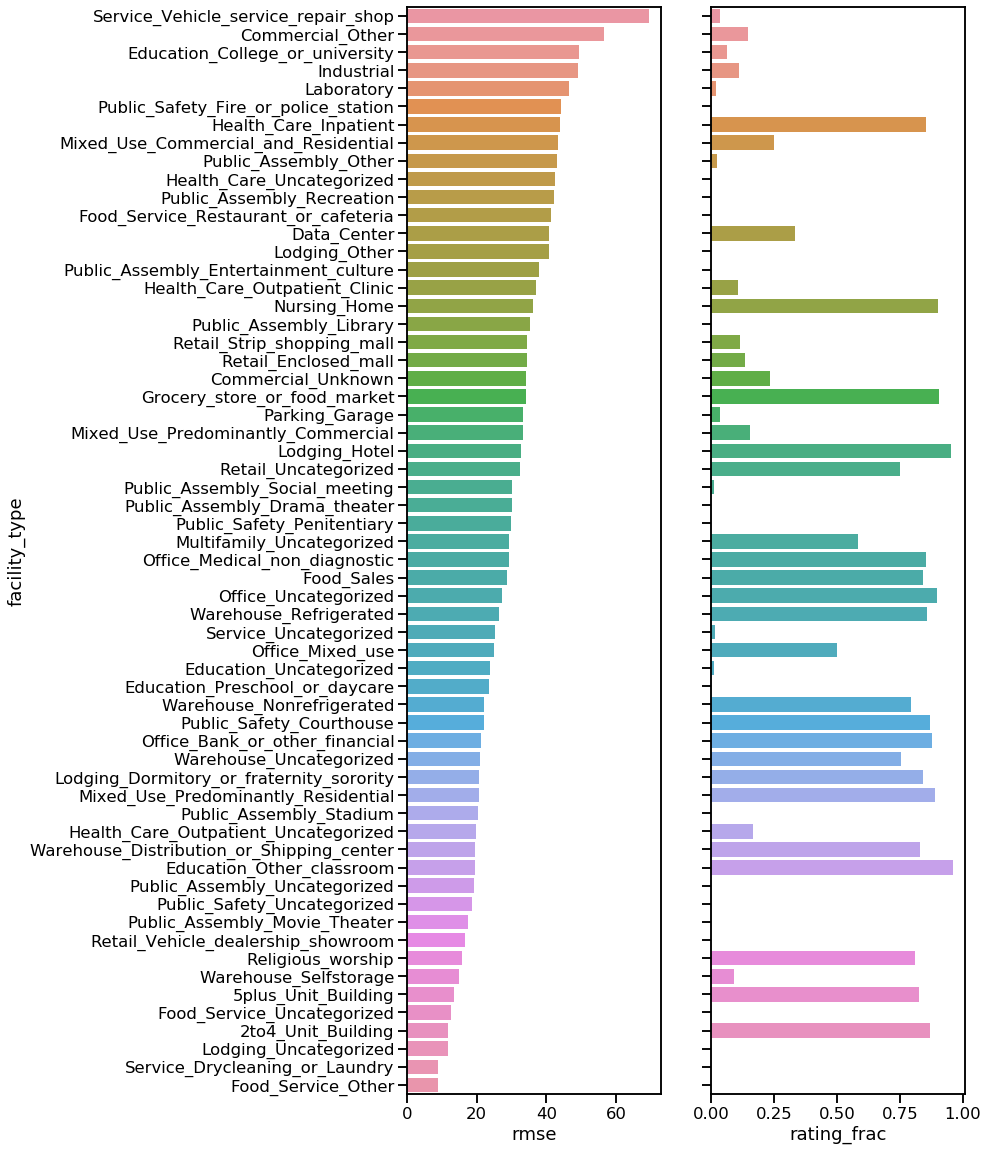

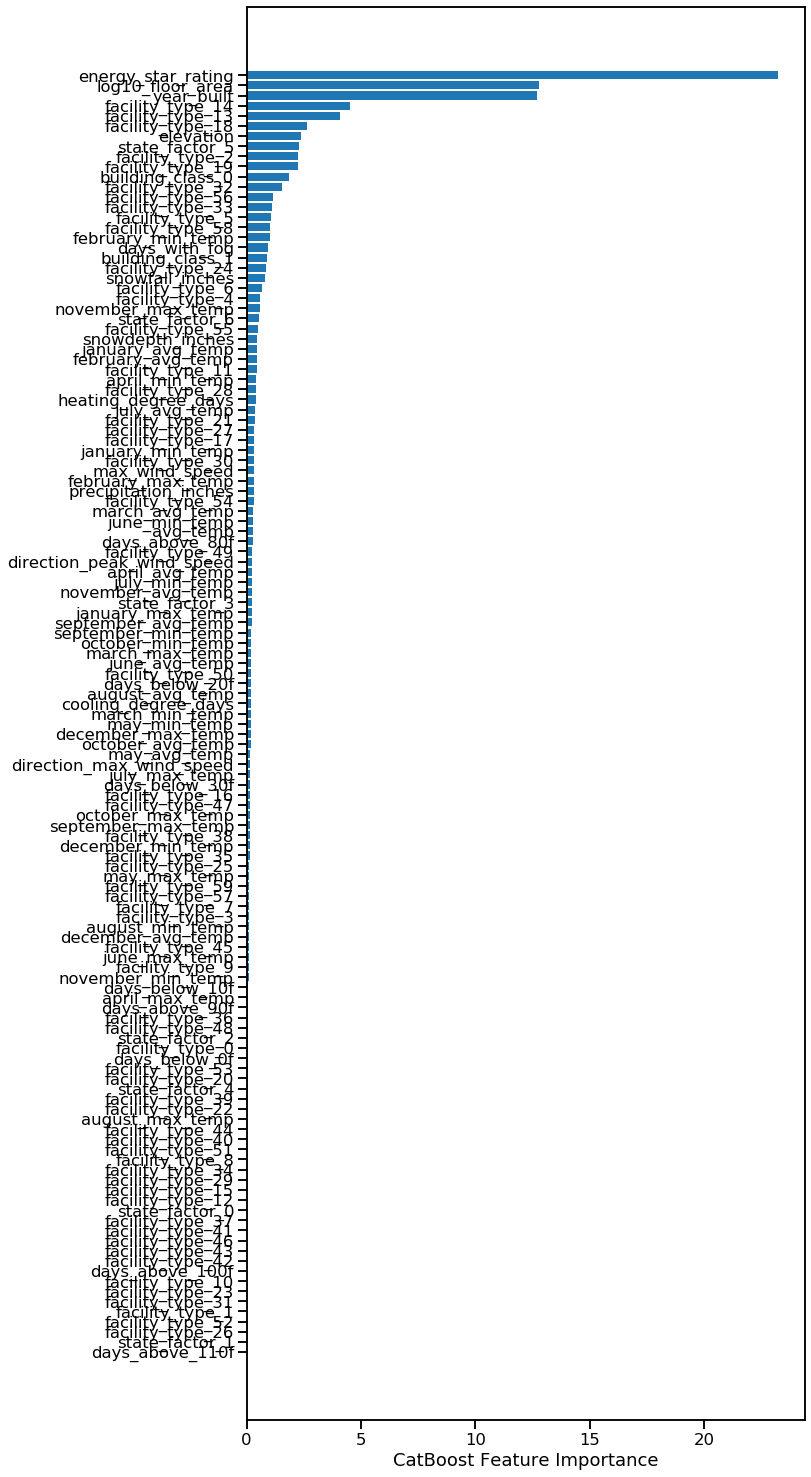

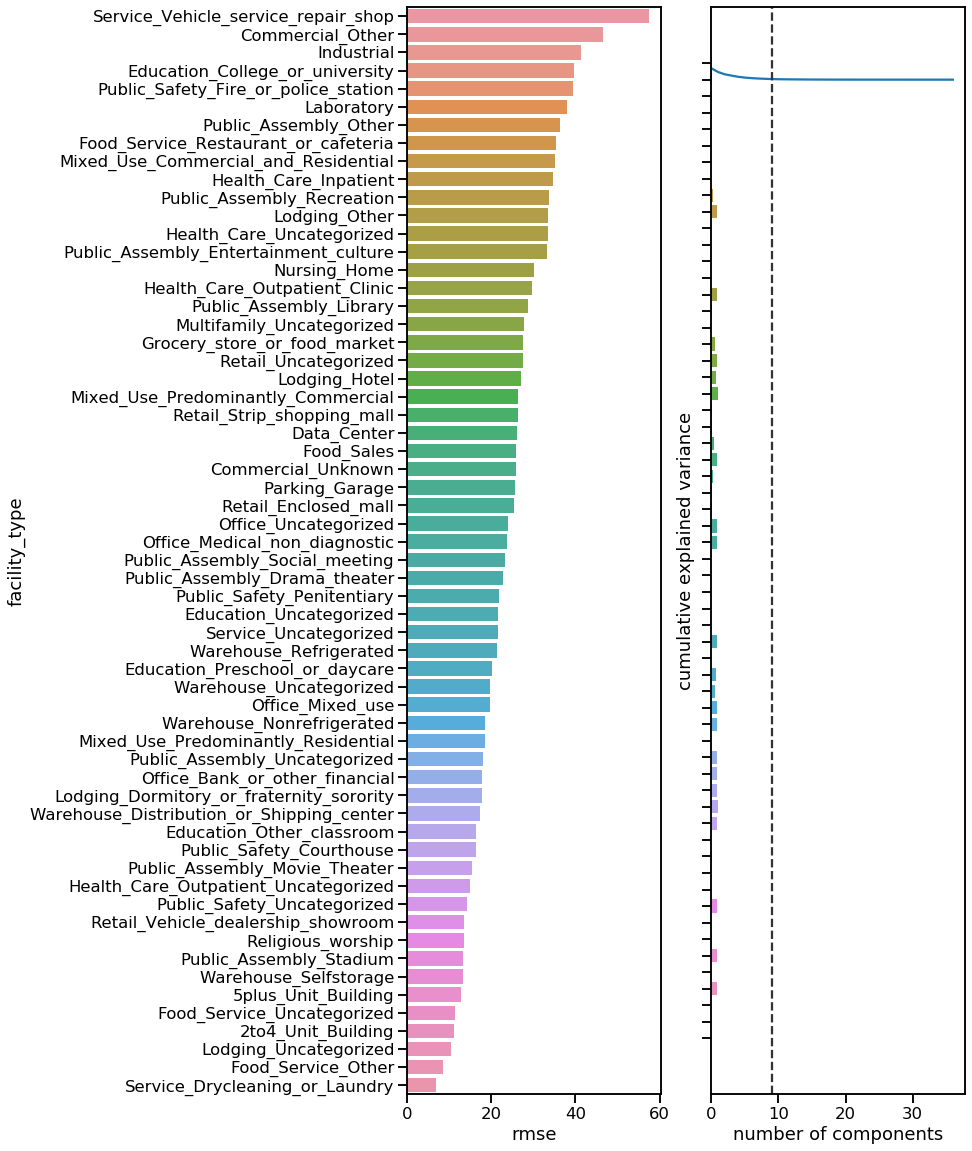

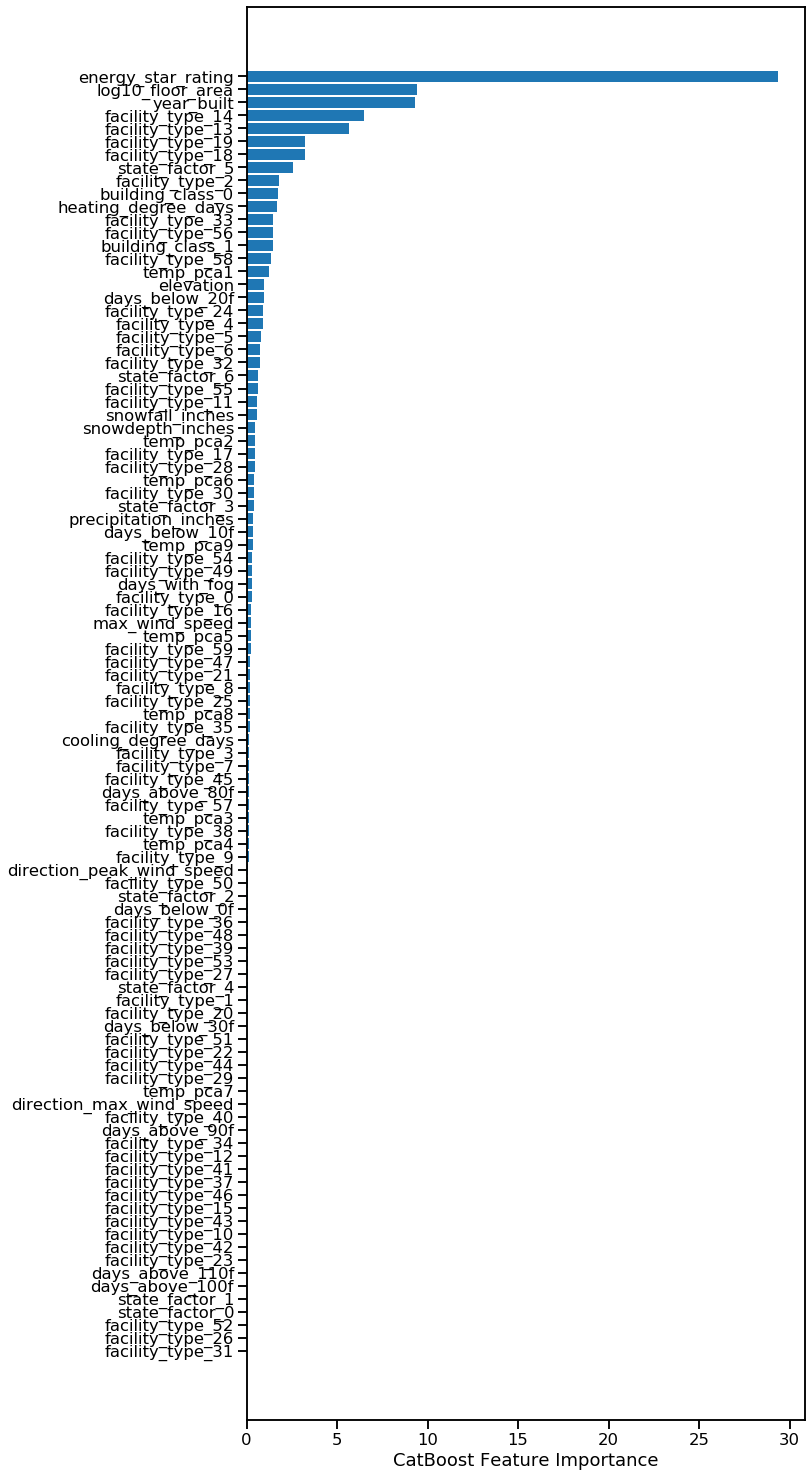

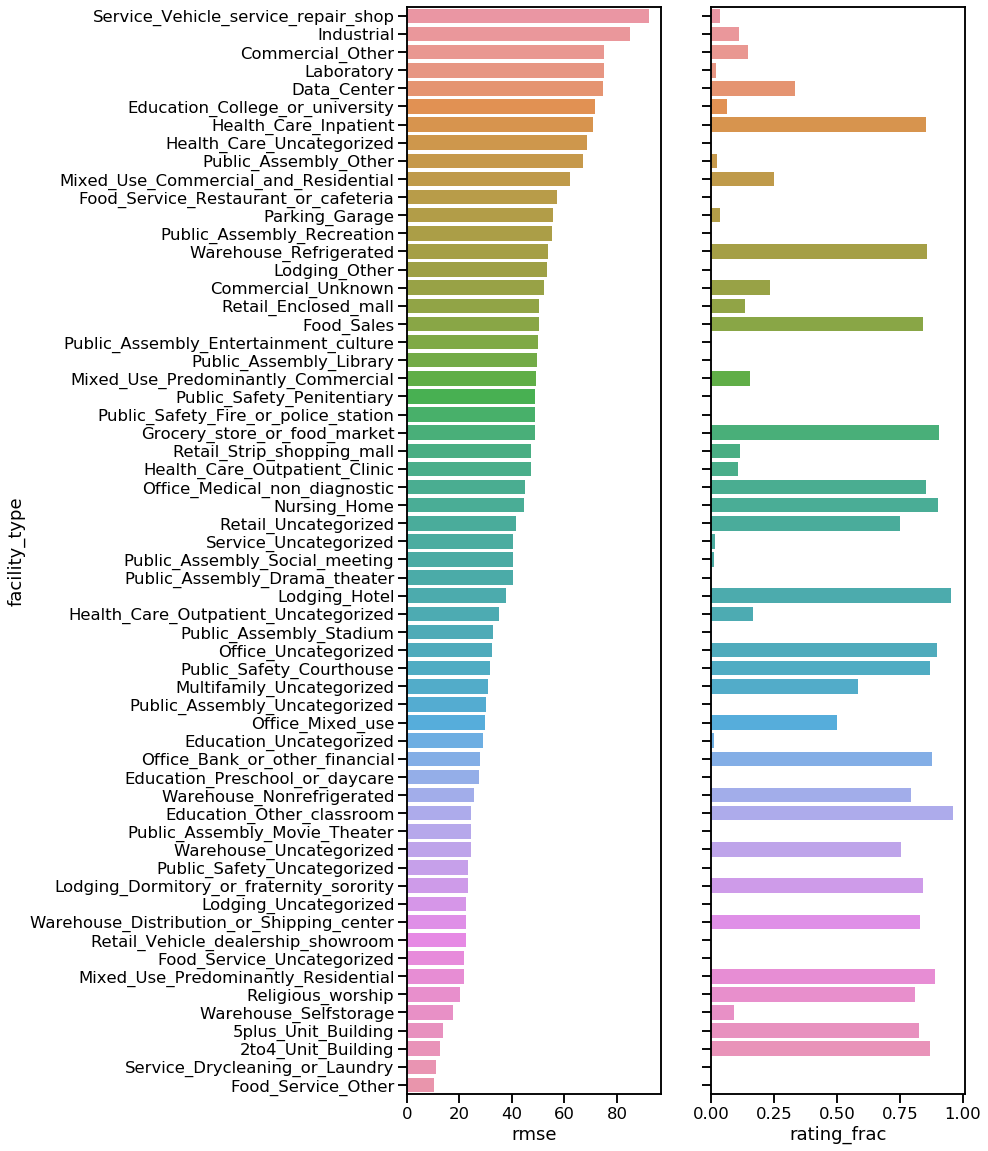

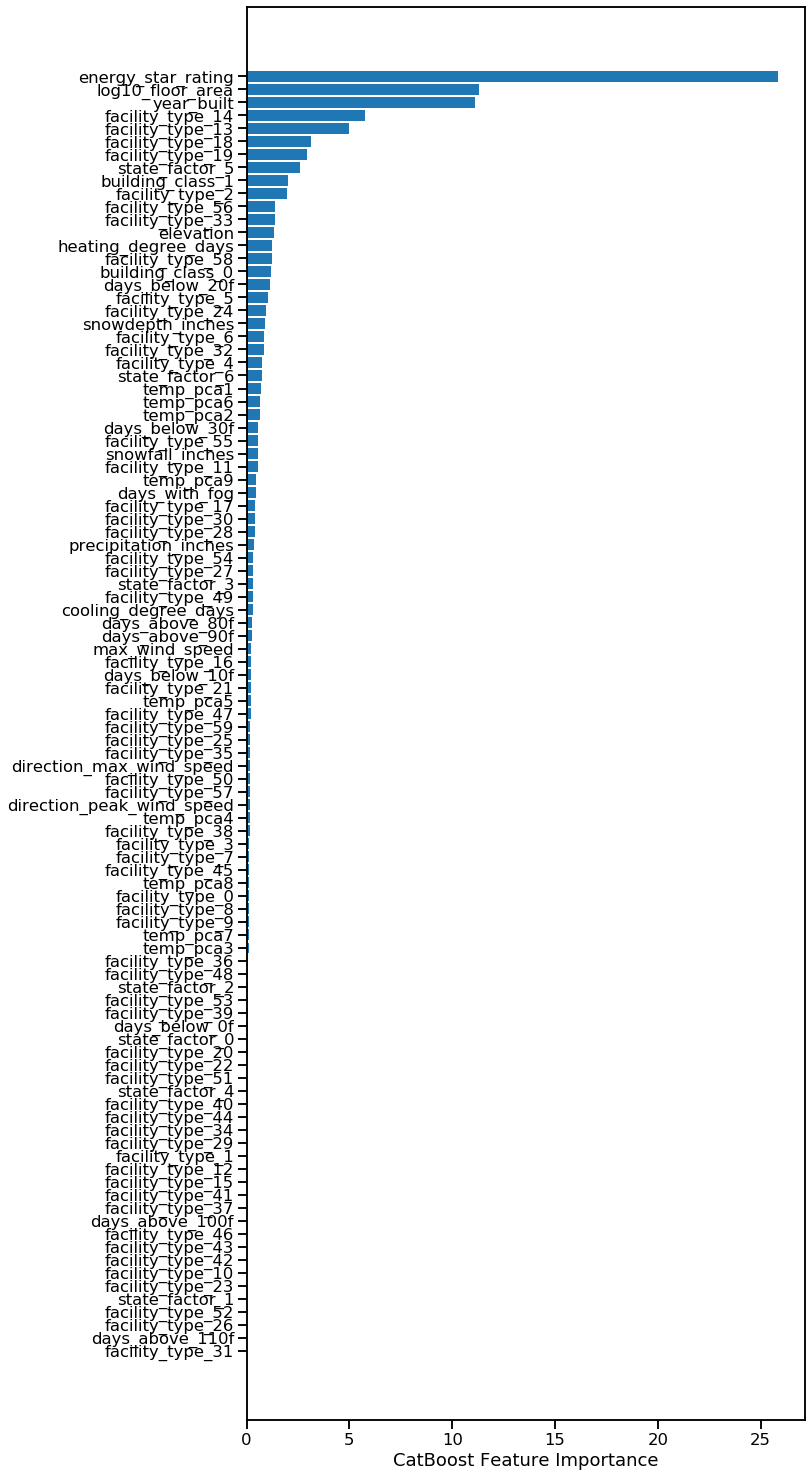

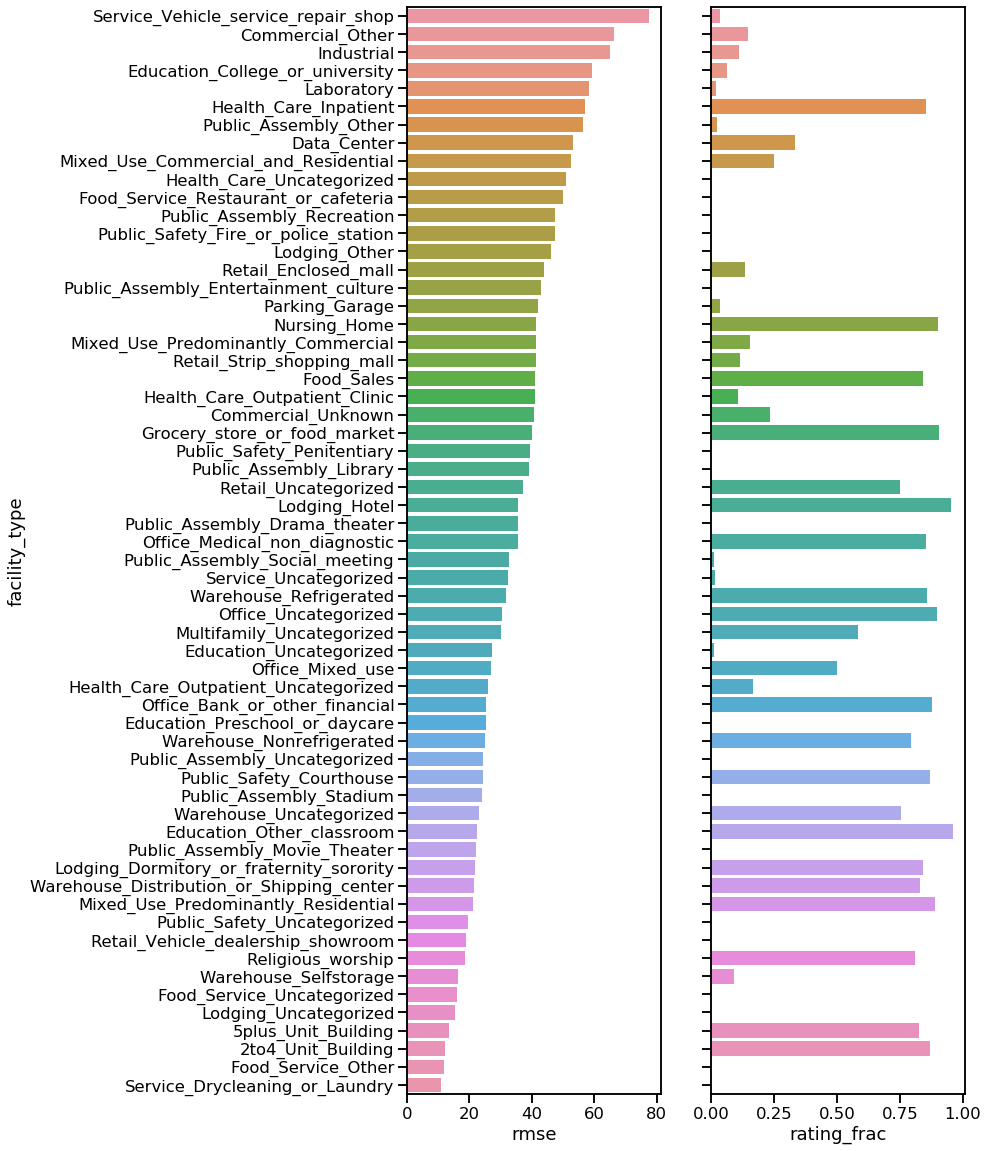

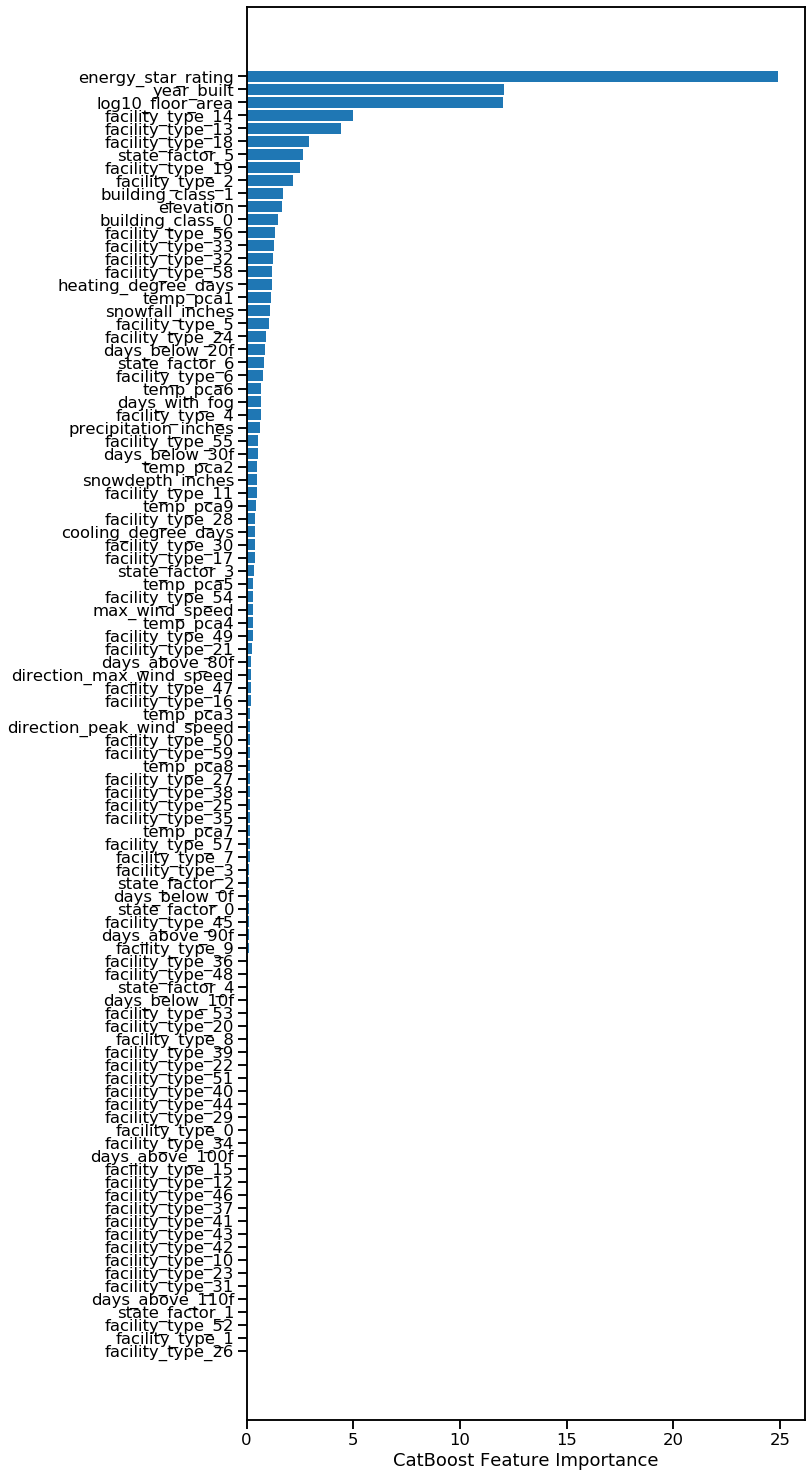

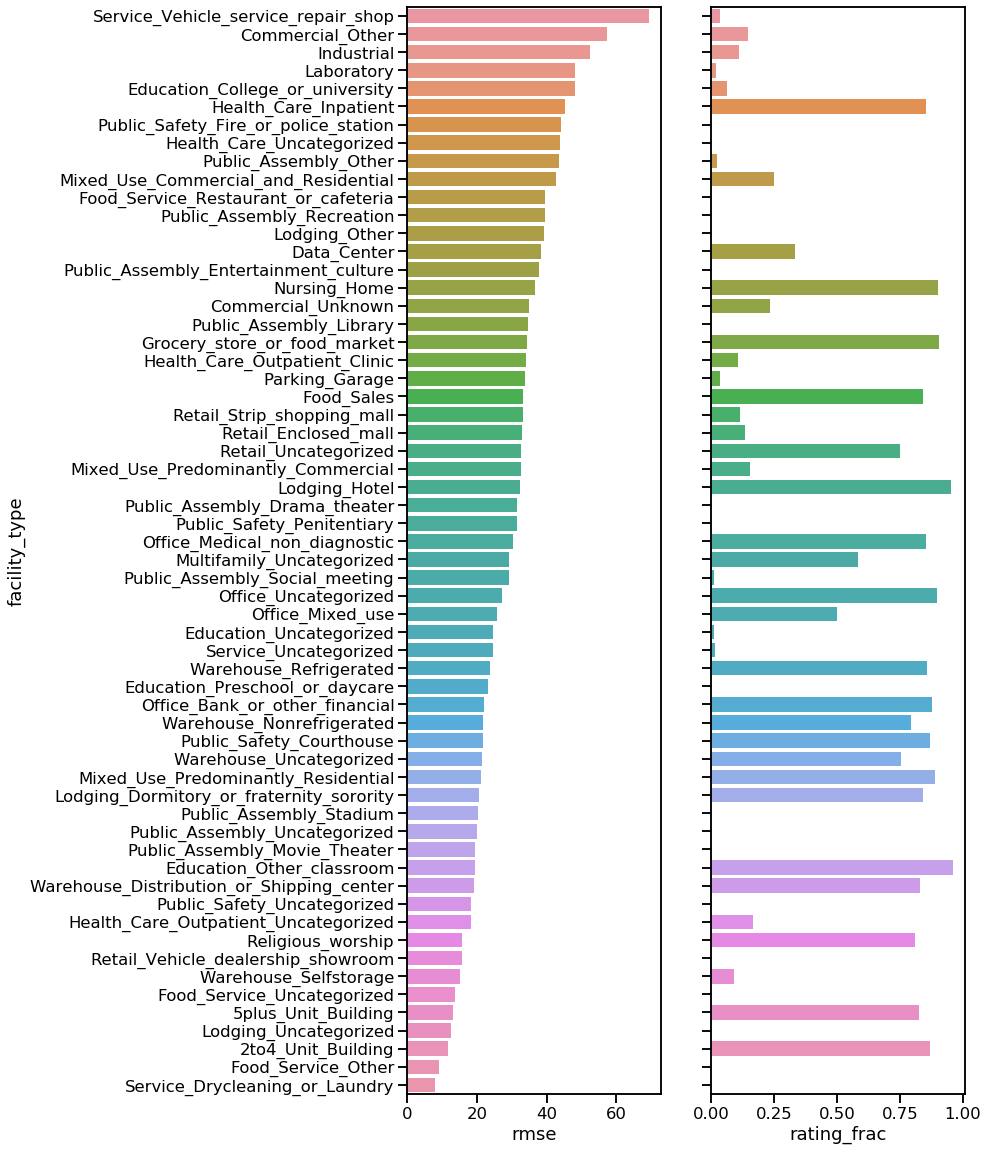

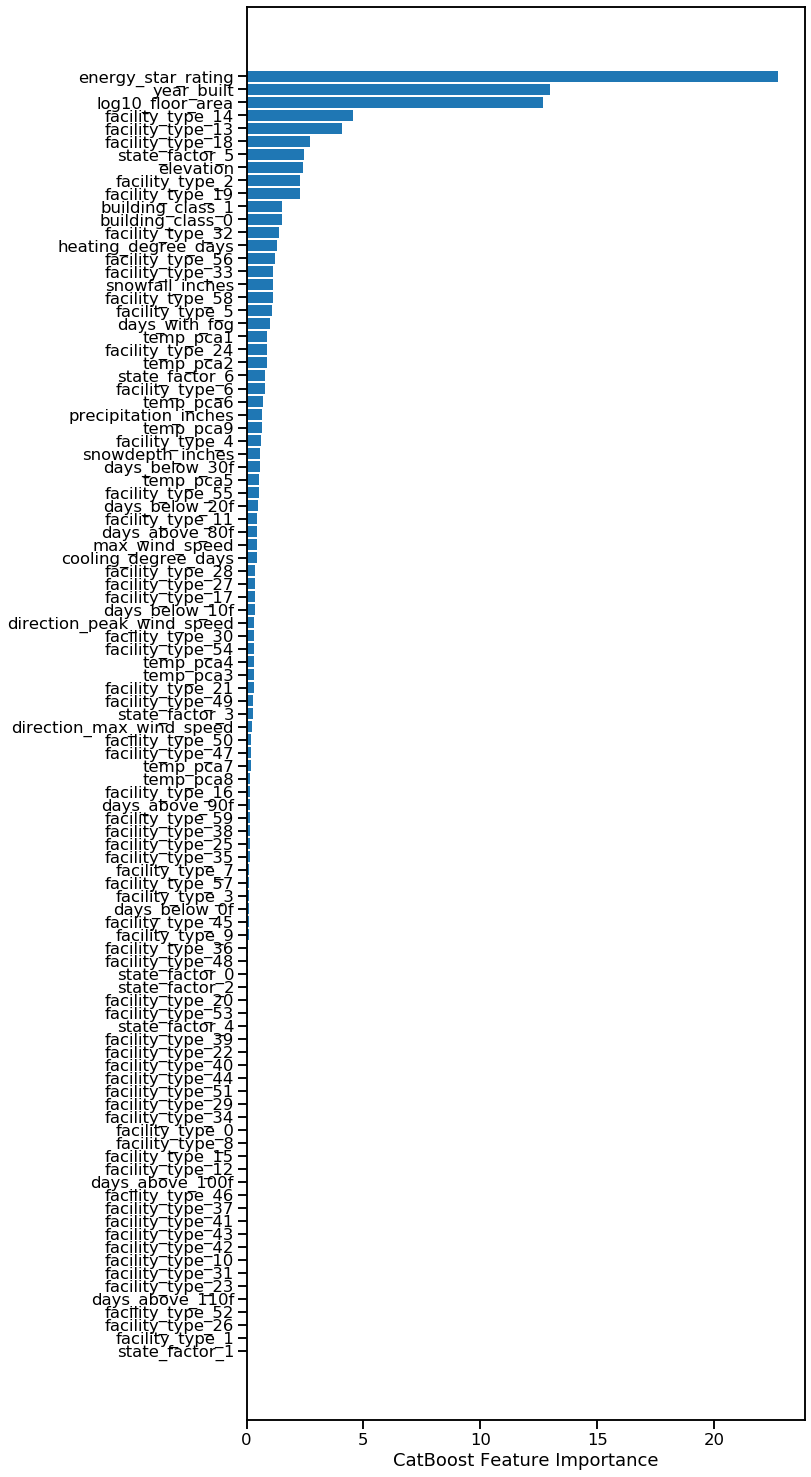

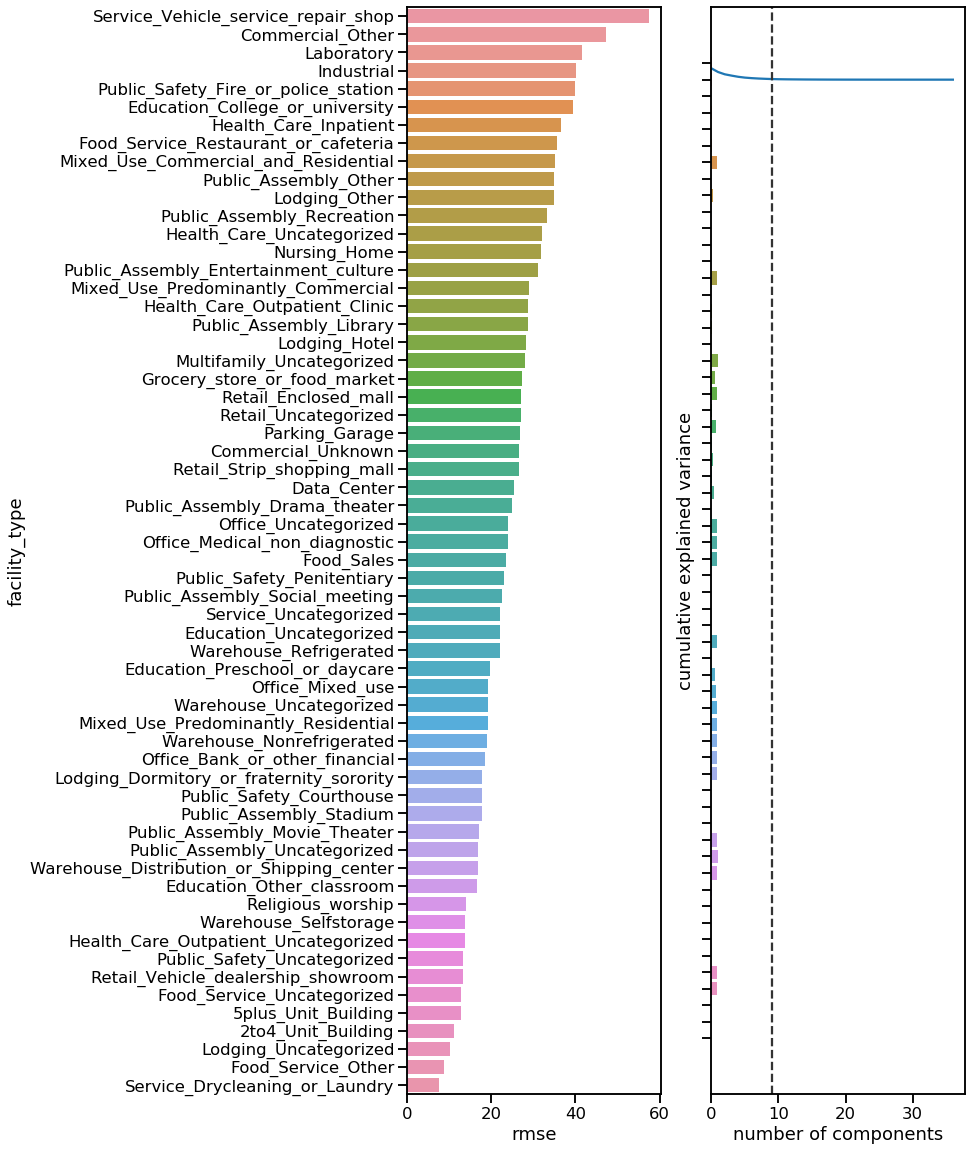

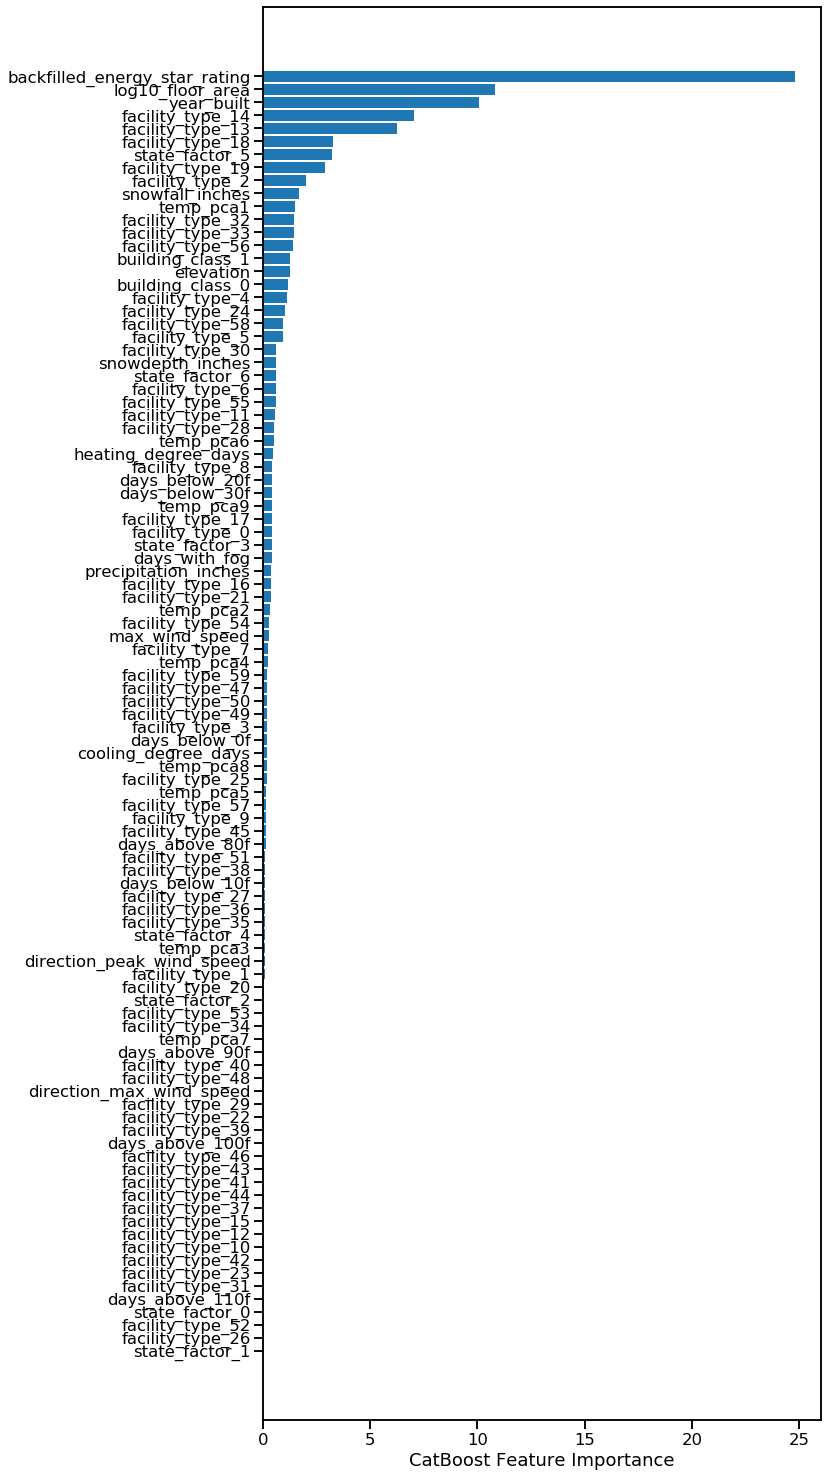

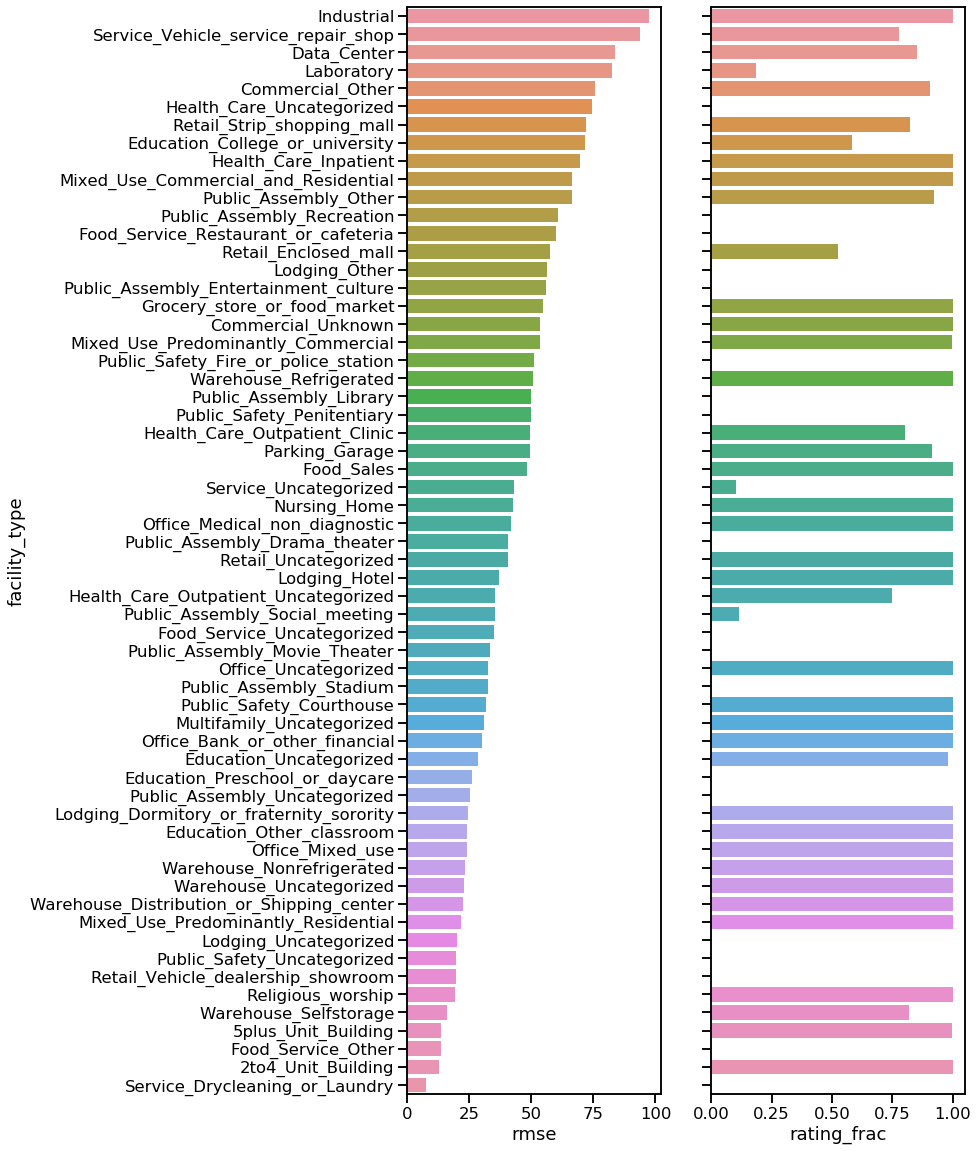

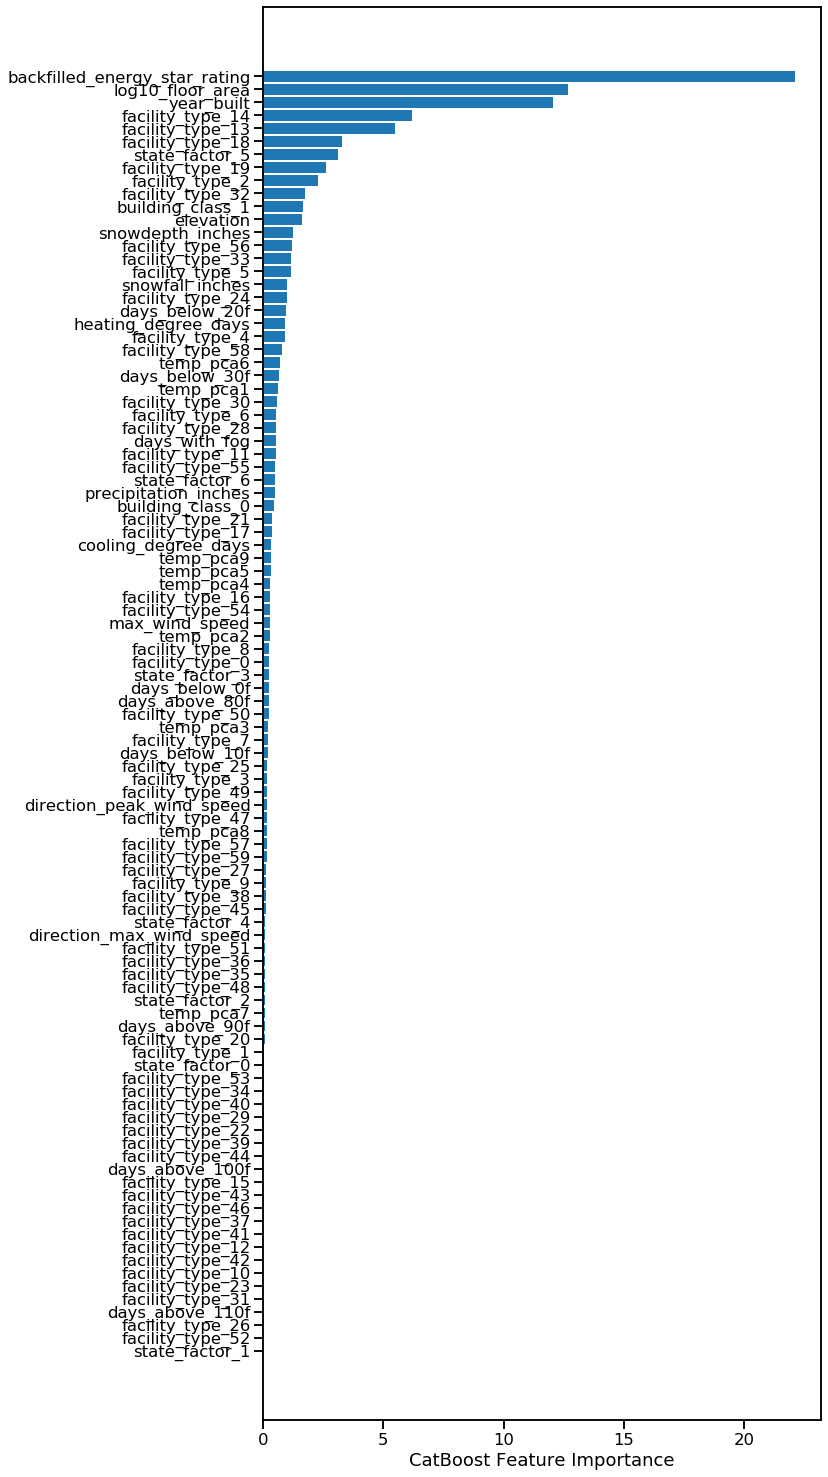

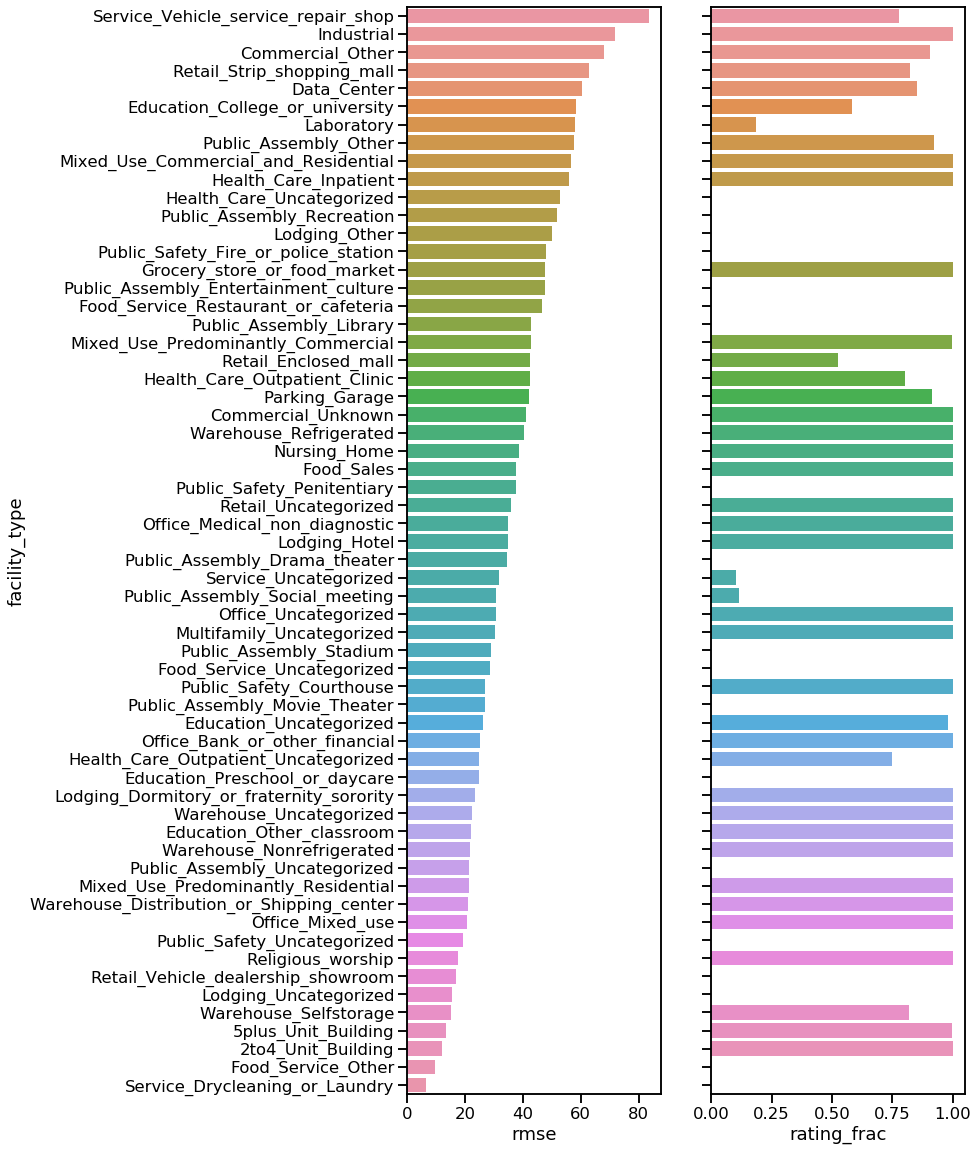

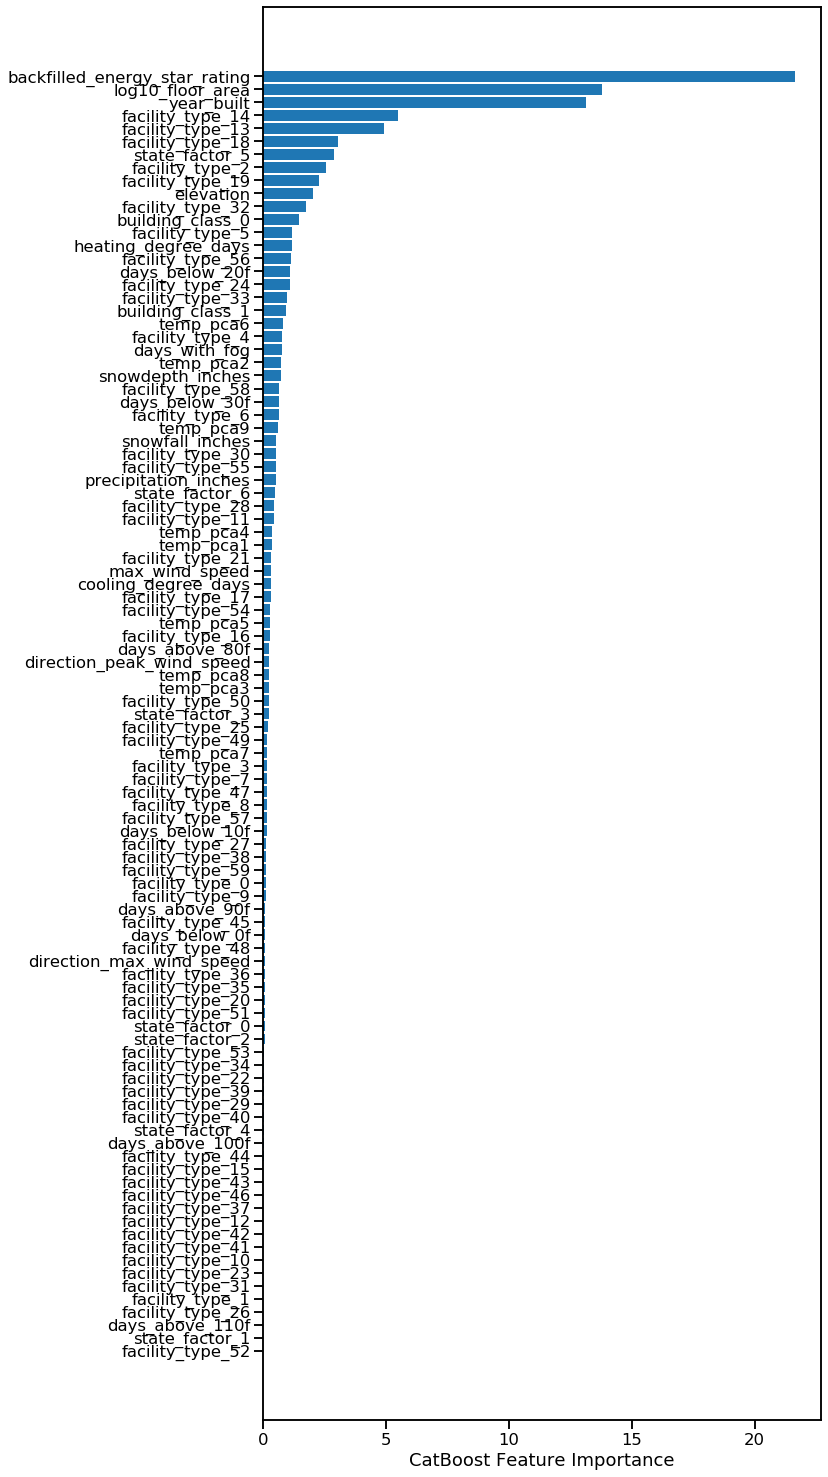

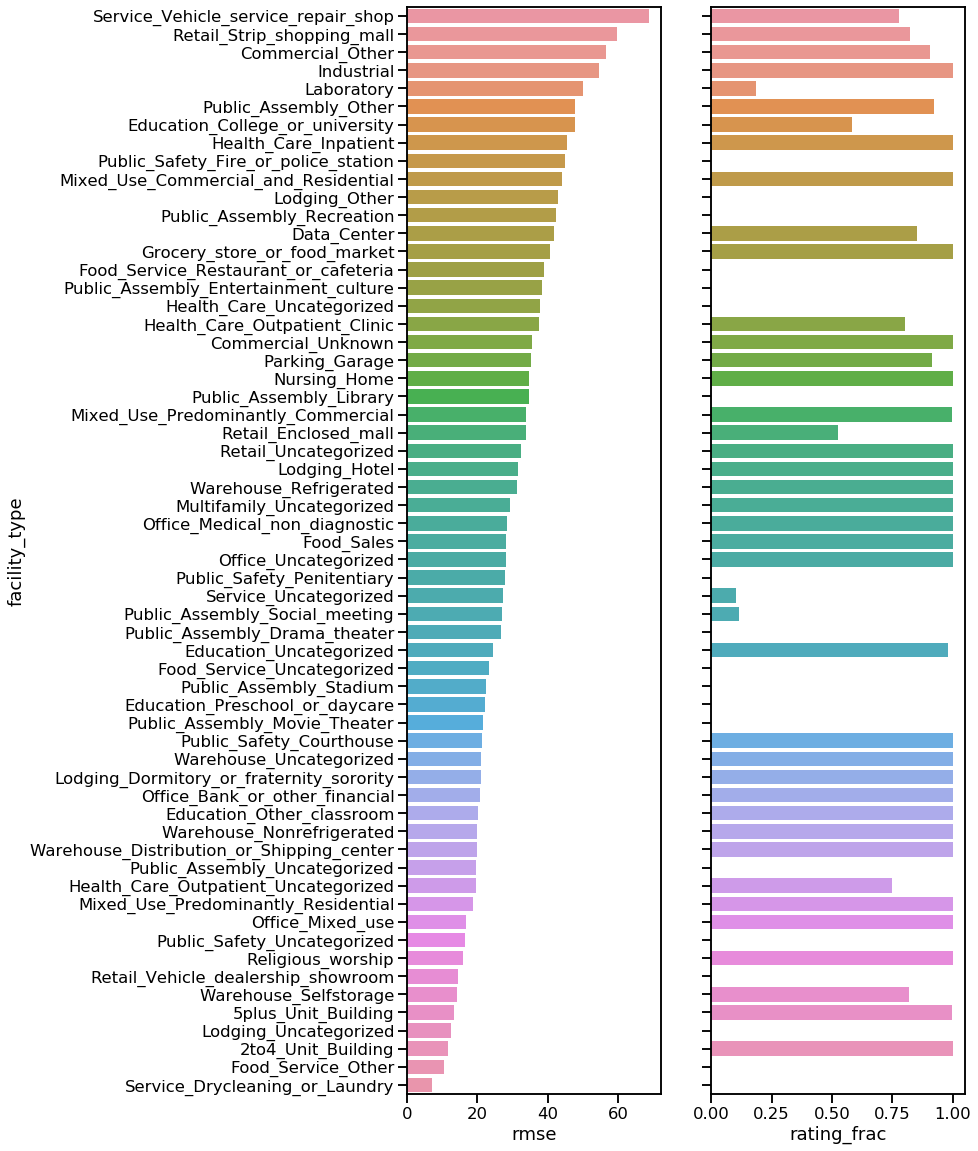

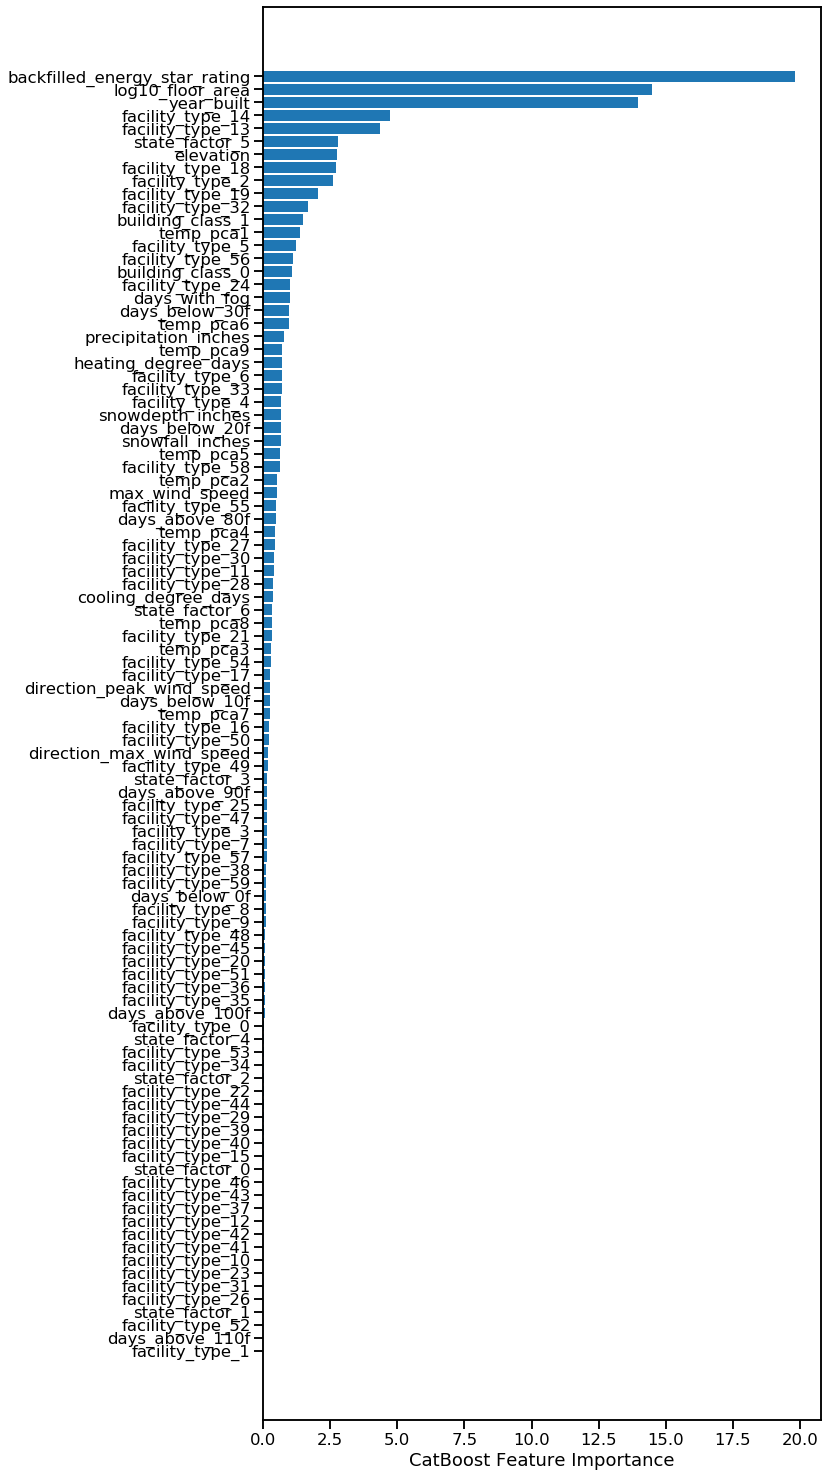

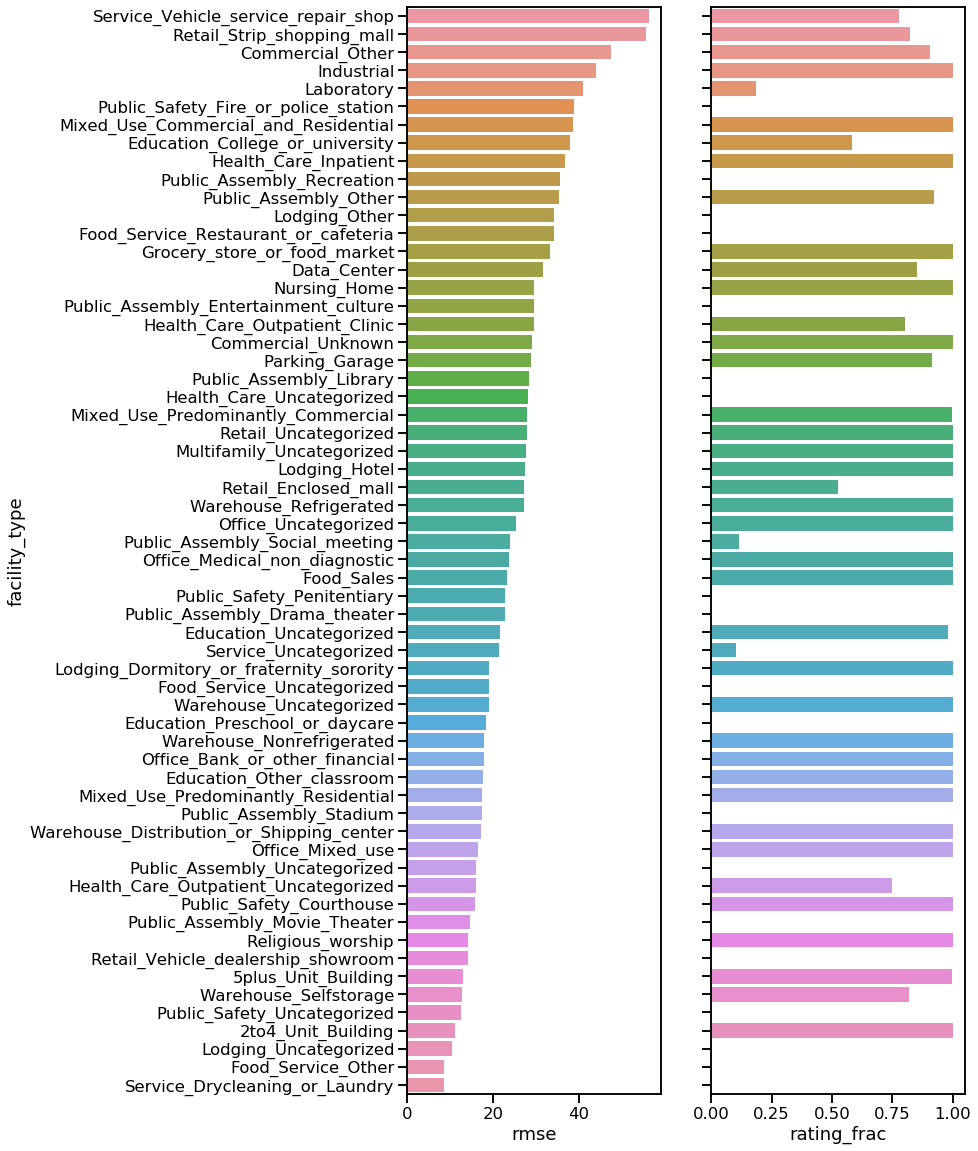

<IPython.core.display.Javascript object>

In [16]:
# Loop for different input configs, hyper parameter values
seed = 0
for config_name in feature_dict.keys():
    cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
    log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
    backfill_dict = feature_dict[config_name]["backfill_dict"]
    if_scale = False
    if_one_hot = feature_dict[config_name]["if_one_hot"]

    train_filter_df, test_filter_df, pca_cols = process_data(
        train_df.drop_duplicates().copy(),
        test_df.drop_duplicates().copy(),
        cols_to_reduce,
        log10_transform_cols,
        0,
        backfill_dict,
    )

    # Set feature columns after data transformations
    features_columns = (
        list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
        + pca_cols
        + [f"log10_{col}" for col in log10_transform_cols]
    )
    if backfill_dict:
        backfill_cols = list(backfill_dict.keys())
        features_columns = list(set(features_columns) - set(backfill_cols)) + [
            f"backfilled_{col}" for col in backfill_cols
        ]
    print(config_name, features_columns, if_one_hot)

    for depth in [6, 8, 10, 12]:  
        model = cb.CatBoostRegressor(
            loss_function="RMSE",
            depth=depth,
            random_seed=seed,
            verbose=False,
            nan_mode="Min",
        )

        ## Run LOY model
        catboost_rmse = mu.run_leave_year_out(
            model_df=train_filter_df,
            ml_model=model,
            features_columns=features_columns,
            if_scale_data=if_scale,
            if_one_hot=if_one_hot,
            model_type="catboost",
        )
        print(f"Average RMSE:\n{catboost_rmse.mean()}")

        ## predict on test data
        train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
            train_filter_df, features_columns
        )
        test_filter_x_df = mu.split_model_feature_response(
            test_filter_df, features_columns, if_with_response=False
        )
        processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
            train_filter_x_df, test_filter_x_df, if_scale, if_one_hot, train_filter_df,
        )

        train_predict, test_predict, fitted_model = mu.run_catboost_model(
            model, processed_train_x_df, train_filter_y_df, processed_test_x_df
        )
        training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
        print(f"Whole data train RMSE: {training_rmse}")

        ## output save result
        catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
        catboost_rmse["method"] = catboost_rmse["left_out_year"].apply(
            lambda x: "loyo" if x > 0 else "whole train"
        )
        display(catboost_rmse)
        catboost_rmse.to_csv(
            f"{wids_path}/validation_result/diana/{config_name}_depth{depth}_seed{seed}.csv",
            index=False,
        )

        test_prediction_result = test_df[["id"]]
        test_prediction_result["site_eui"] = test_predict
        test_prediction_result.to_csv(
            f"{wids_path}/prediction_result/diana/{config_name}_depth{depth}_seed{seed}.csv",
            index=False,
        )

        plot_catboost_feature_importance(model)
        plt.savefig(
            f"{wids_path}/validation_result/diana/{config_name}_feature_importance_depth{depth}_seed{seed}.png"
        )

        rmse_df = get_rmse_by_group(
            train_filter_x_df.rename(
                columns={"backfilled_energy_star_rating": "energy_star_rating"}
            ),
            train_filter_y_df,
            train_predict,
        )
        plot_rmse_by_group(rmse_df)
        plt.savefig(
            f"{wids_path}/validation_result/diana/{config_name}_rmse_by_group_depth{depth}_seed{seed}.png"
        )

In [14]:
fitted_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 9,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.08111999928951263,
 'score_function': 'Cosine',
 'task_type'

<IPython.core.display.Javascript object>

In [10]:
model.get_all_params()

{'nan_mode': 'Max',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 12,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.08111999928951263,
 'score_function': 'Cosine',
 'task_type

<IPython.core.display.Javascript object>

In [10]:
# fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#                  x='left_out_year', y='value', hue='variable', ax = axes[0])
# axes[0].legend([])
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#             x='method', y='value', hue='variable', ax=axes[1])
# axes[1].legend(bbox_to_anchor=(1,1))
# plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_summary.png")

<IPython.core.display.Javascript object>

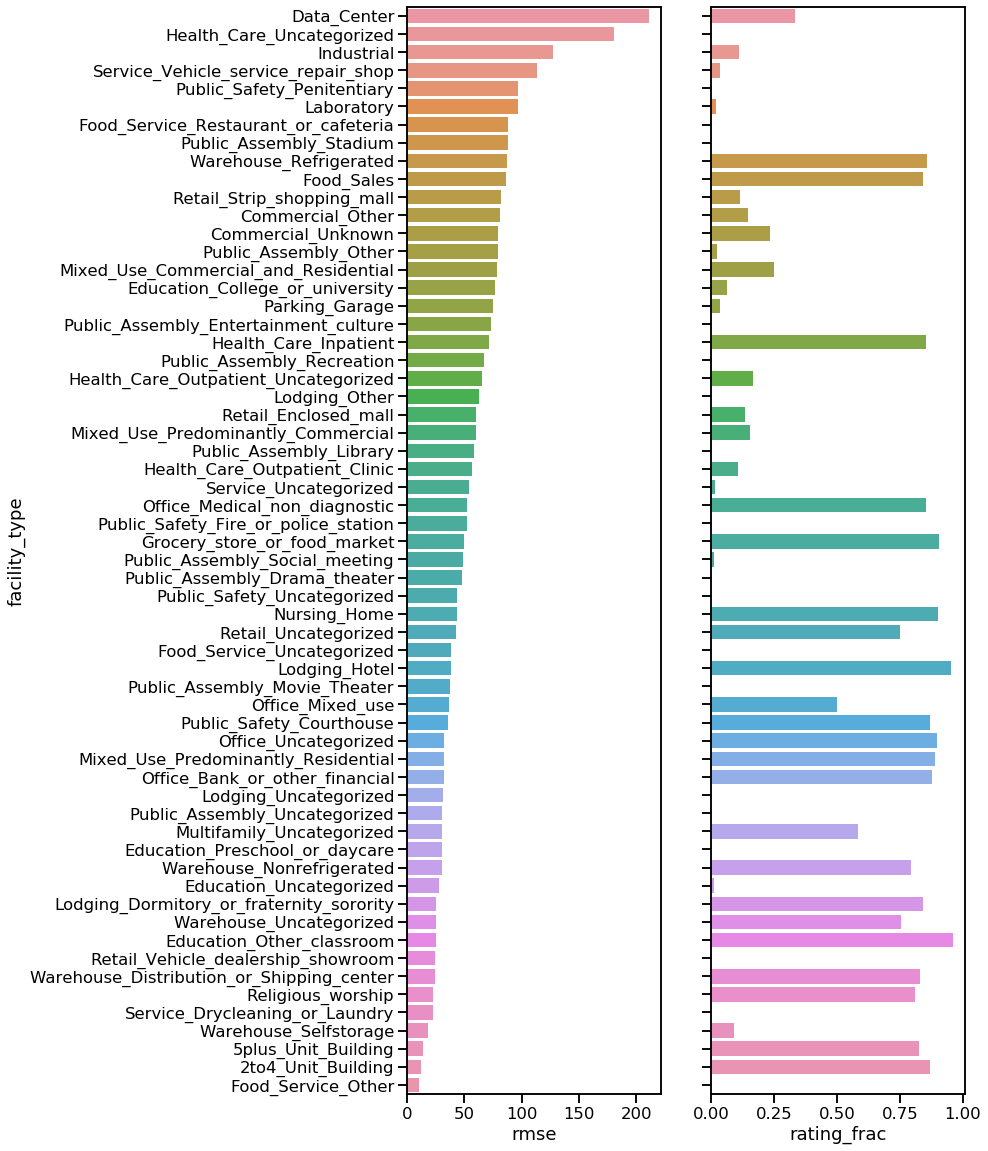

<IPython.core.display.Javascript object>

# Dev cells below this point

In [13]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

<IPython.core.display.Javascript object>

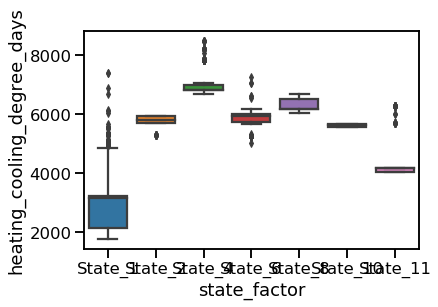

In [14]:
train_filter_df['heating_cooling_degree_days'] = train_filter_df['heating_degree_days'] + train_filter_df['cooling_degree_days']
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_cooling_degree_days')

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


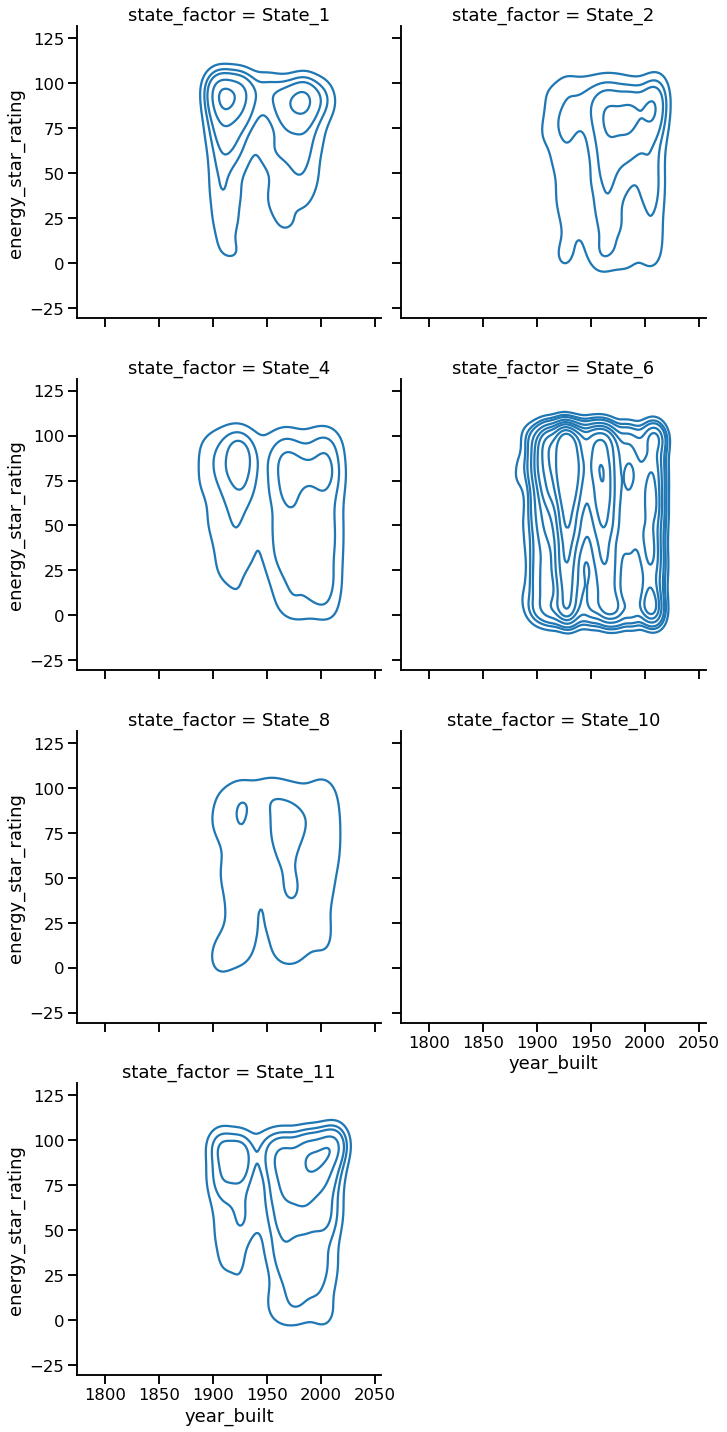

In [40]:
sns.displot(data=train_df.query("year_built>1800"), x='year_built', y='energy_star_rating', col='state_factor',
            col_wrap=2, kind='kde')

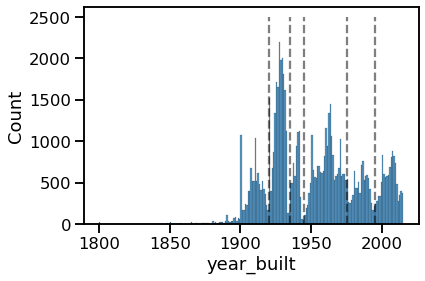

In [31]:
ax = sns.histplot(train_filter_df['year_built'], binwidth=1)
year_built_bins = [1800, 1920, 1935, 1945, 1975, 1995, 2022]
ax.vlines(year_built_bins, ymin=0, ymax=2500, linestyles='--', alpha=0.5)

# norm = plt.Normalize(train_filter_df['site_eui'].min(), train_filter_df['site_eui'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

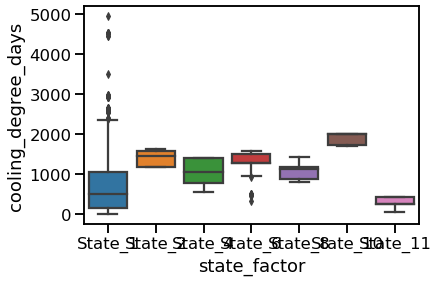

In [12]:
sns.boxplot(data=train_filter_df, x='state_factor', y='cooling_degree_days')

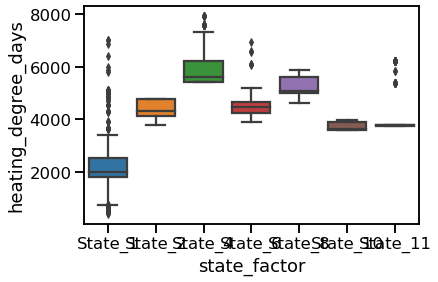

In [13]:
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_degree_days')

In [7]:
merged_train_df = combine_features_and_prediction(train_filter_x_df, train_filter_y_df, train_predict)

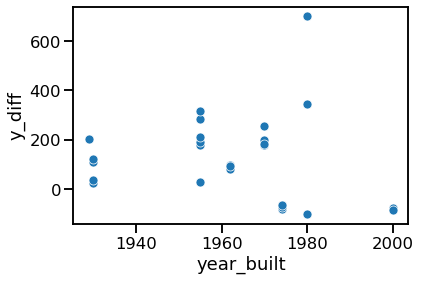

In [16]:
sns.scatterplot(data=merged_train_df.query("facility_type == 'Data_Center'"), x='year_built', y='y_diff')

In [20]:
merged_train_df.query("facility_type == 'Data_Center'")

days_with_fog  max_wind_speed  year_built  energy_star_rating  \
13               NaN             1.0      1955.0                13.0   
930             88.0             1.0      1955.0                14.0   
1291             NaN             NaN      1955.0                19.0   
2505             NaN             NaN      1955.0                24.0   
3599             NaN             NaN      1955.0                20.0   
4195             NaN             NaN      2000.0                 NaN   
4640             NaN             NaN      1955.0                 1.0   
5239             NaN             NaN      2000.0                 NaN   
14842           12.0             1.0      1980.0                99.0   
26916           93.0             1.0      1974.0                39.0   
27157           93.0             1.0      1930.0                 NaN   
28482            NaN             NaN      1970.0                 NaN   
35511            NaN             1.0      1974.0                 NaN   
35778            NaN             1.0      1930.0                 NaN   
37286            NaN             1.0      1970.0                 NaN   
44999          110.0            13.0      1974.0                 NaN   
45268            NaN             NaN      1930.0                 NaN   
46943          148.0            18.3      1970.0               100.0   
53372            NaN             1.0      1980.0                 NaN   
53373            NaN             1.0      1980.0                 NaN   
56317          131.0             NaN      1974.0                 NaN   
56723          106.0             1.0      1930.0                 NaN   
58730          131.0             NaN      1970.0                 NaN   
66262            NaN             NaN      1962.0                 NaN   
67079            NaN             NaN      1962.0                 NaN   
67461            NaN             NaN      1929.0                 NaN   
67964            NaN             NaN      1962.0                 NaN   

       direction_max_wind_speed facility_type  direction_peak_wind_speed  \
13                          1.0   Data_Center                        1.0   
930                         1.0   Data_Center                        1.0   
1291                        NaN   Data_Center                        NaN   
2505                        NaN   Data_Center                        NaN   
3599                        NaN   Data_Center                        NaN   
4195                        NaN   Data_Center                        NaN   
4640                        NaN   Data_Center                        NaN   
5239                        NaN   Data_Center                        NaN   
14842                       1.0   Data_Center                        1.0   
26916                       1.0   Data_Center                        1.0   
27157                       1.0   Data_Center                        1.0   
28482                       NaN   Data_Center                        NaN   
35511                       1.0   Data_Center                        1.0   
35778                       1.0   Data_Center                        1.0   
37286                       1.0   Data_Center                        1.0   
44999                     310.0   Data_Center                      310.0   
45268                       NaN   Data_Center                        NaN   
46943                     330.0   Data_Center                      340.0   
53372                       1.0   Data_Center                        1.0   
53373                       1.0   Data_Center                        1.0   
56317                       NaN   Data_Center                        NaN   
56723                       1.0   Data_Center                        1.0   
58730                       NaN   Data_Center                        NaN   
66262                       NaN   Data_Center                        NaN   
67079                       NaN   Data_Center                        NaN   
67461         